In [3]:
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt

sys.path.append("../../")
sys.path.append("../")
import NMC as models
import importlib
import os
import ot
import glob
import pandas as pd
import scipy.sparse as sp
import anndata as ad
from src import util
from tqdm import tqdm
from torchdiffeq import odeint
import torch.nn as nn
import torch.nn.functional as F

2025-01-29 11:52:18.753999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 11:52:18.846388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 11:52:18.881578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 11:52:18.891978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 11:52:18.953518: I tensorflow/core/platform/cpu_feature_guar

# Data Loading

In [4]:
T = 5
class DataLoader:
    def __init__(self, data_path, dataset_type="Synthetic"):
        """
        Initialize DataLoader

        Args:
            data_path: Path to data directory
            dataset_type: Either "Synthetic" or "Curated"
        """
        self.data_path = os.path.join(data_path, dataset_type)
        self.dataset_type = dataset_type
        self.adatas = None
        self.kos = None
        self.true_matrix = None

    def load_data(self):
        """Load and preprocess data"""
        if self.dataset_type == "Synthetic":
            paths = glob.glob(
                os.path.join(self.data_path, "dyn-TF/dyn-TF*-1")
            ) + glob.glob(os.path.join(self.data_path, "dyn-TF_ko*/dyn-TF*-1"))
        elif self.dataset_type == "Curated":
            paths = glob.glob(os.path.join(self.data_path, f"HSC*/HSC*-1"))
        else:
            raise ValueError(f"Unknown dataset type: {self.dataset_type}")

        self.adatas = [util.load_adata(p) for p in paths]

        df = pd.read_csv(os.path.join(os.path.dirname(paths[0]), "refNetwork.csv"))

        n_genes = self.adatas[0].n_vars

        self.true_matrix = pd.DataFrame(
            np.zeros((n_genes, n_genes), int),
            index=self.adatas[0].var.index,
            columns=self.adatas[0].var.index,
        )

        for i in range(df.shape[0]):
            _i = df.iloc[i, 1]
            _j = df.iloc[i, 0]  
            _v = {"+": 1, "-": -1}[df.iloc[i, 2]]  # interaction type
            self.true_matrix.loc[_i, _j] = _v

        t_bins = np.linspace(0, 1, T + 1)[:-1]
        for adata in self.adatas:
            adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins) - 1

        self.kos = []
        for p in paths:
            try:
                self.kos.append(os.path.basename(p).split("_ko_")[1].split("-")[0])
            except:
                self.kos.append(None)

        self.gene_to_index = {
            gene: idx for idx, gene in enumerate(self.adatas[0].var.index)
        }
        self.ko_indices = []
        for ko in self.kos:
            if ko is None:
                self.ko_indices.append(None)
            else:
                self.ko_indices.append(self.gene_to_index[ko])

In [105]:
T = 5
data_loader = DataLoader("../../data/simulation", dataset_type="Synthetic")
data_loader.load_data()
adatas, kos, ko_indices, true_matrix = (
    data_loader.adatas,
    data_loader.kos,
    data_loader.ko_indices,
    data_loader.true_matrix.values,
)

In [110]:
for i, ad in enumerate(adatas):
    ko_gene_idx = ko_indices[i]  # or check kos[i] for a gene name
    if ko_gene_idx is None:
        print(f"Dataset {i} is wild-type, no KO specified.")
        continue
    
    # Inspect the expression of that gene in ad.X
    gene_expr = ad.X[:, ko_gene_idx]
    
    # Let's check if it's effectively zero
    min_val = gene_expr.min()
    max_val = gene_expr.max()
    mean_val = gene_expr.mean()

    print(f"Dataset {i} (KO={kos[i]}), gene_idx={ko_gene_idx}:")
    print(f"   min={min_val:.3f}, max={max_val:.3f}, mean={mean_val:.3f}")
    near_zero_fraction = np.mean(gene_expr < 1e-3)
    print(f"   Fraction of cells below 1e-5: {near_zero_fraction:.2%}")

Dataset 0 is wild-type, no KO specified.
Dataset 1 (KO=g8), gene_idx=7:
   min=0.000, max=0.201, mean=0.020
   Fraction of cells below 1e-5: 7.00%
Dataset 2 (KO=g4), gene_idx=3:
   min=0.000, max=0.214, mean=0.021
   Fraction of cells below 1e-5: 8.60%
Dataset 3 (KO=g3), gene_idx=2:
   min=0.000, max=0.337, mean=0.020
   Fraction of cells below 1e-5: 7.30%
Dataset 4 (KO=g7), gene_idx=6:
   min=0.000, max=0.198, mean=0.020
   Fraction of cells below 1e-5: 8.10%
Dataset 5 (KO=g5), gene_idx=4:
   min=0.000, max=0.217, mean=0.020
   Fraction of cells below 1e-5: 7.90%
Dataset 6 (KO=g6), gene_idx=5:
   min=0.000, max=0.176, mean=0.019
   Fraction of cells below 1e-5: 9.70%
Dataset 7 (KO=g2), gene_idx=1:
   min=0.000, max=0.301, mean=0.020
   Fraction of cells below 1e-5: 7.20%


In [8]:
from sklearn.preprocessing import StandardScaler

def prepare_time_binned_data(adata, time_column='t'):
    """
    Groups cells by their time bins and returns a list of tensors.
    
    Args:
        adata (AnnData): The AnnData object containing cell data.
        time_column (str): The column in adata.obs indicating time bins.
        
    Returns:
        List[torch.Tensor]: A list where each element is a tensor of cells at a specific time bin.
    """
    num_time_bins = adata.obs[time_column].nunique()
    time_bins = sorted(adata.obs[time_column].unique())
    grouped_data = []
    for t in time_bins:
        cells_t = adata[adata.obs[time_column] == t].X
        if isinstance(cells_t, sp.spmatrix):
            cells_t = cells_t.toarray()
        grouped_data.append(torch.from_numpy(cells_t).float())
    return grouped_data

def normalize_data(grouped_data):
    """
    Applies Z-score normalization to each gene across all cells.
    
    Args:
        grouped_data (List[torch.Tensor]): List of tensors grouped by time bins.
        
    Returns:
        List[torch.Tensor]: Normalized data.
    """
    all_cells = torch.cat(grouped_data, dim=0)
    scaler = StandardScaler()
    all_cells_np = all_cells.numpy()
    scaler.fit(all_cells_np)

    normalized_data = []
    for tensor in grouped_data:
        normalized = torch.from_numpy(scaler.transform(tensor.numpy())).float()
        normalized_data.append(normalized)
    return normalized_data, scaler

In [9]:
grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

In [10]:
normalized_data[1].shape

torch.Size([186, 8])

# Discrete time NODE in order sequentially

In [458]:
from geomloss import SamplesLoss

def train_sequential_discrete_time_ode(
    func,
    normalized_data,
    n_steps_per_transition=2500,
    plot_freq=1000,
    l1_reg=0.0,
    l2_reg=0.05,
    alpha_wass=0.1,
    plot=True,
    device="cpu"
):
    """
    Train Neural ODE on discrete, sequentially binned time points.

    Args:
        func (nn.Module): The neural ODE function (e.g., MLPODEF instance).
        normalized_data (List[torch.Tensor]): List of tensors grouped by time bins.
        n_steps_per_transition (int): Number of training steps per transition.
        plot_freq (int): Frequency of plotting results.
        l1_reg (float): L1 regularization strength.
        l2_reg (float): L2 regularization strength.
        plot (bool): Whether to plot during training.
        device (str or torch.device): Device to run training on.
    """
    horizon = 1  # Each transition is ti -> ti+1
    batch_time = horizon
    num_time_bins = len(normalized_data)
    num_transitions = num_time_bins - 1
    num_variables = normalized_data[0].shape[1]
    

    transition_times = torch.tensor([0.0, 1.0]).to(device)  # [2]

    sinkhorn_loss = SamplesLoss(
        "sinkhorn",
        p=2,        
        blur=0.05,
        backend="auto"
    )

    def create_batch_for_transition(t_start, batch_size):
        """
        Create a batch for a specific transition from ti to ti+1.

        Args:
            t_start (int): Starting time bin index.
            batch_size (int): Number of samples in the batch.

        Returns:
            Tuple: (x0, t, x1)
                - x0: Initial states at ti, shape [batch_size, num_variables]
                - t: Time tensor, shape [2]
                - x1: Target states at ti+1, shape [batch_size, num_variables]
        """
        # Sample batch_size cells from ti and ti+1
        cells_t0 = normalized_data[t_start]
        cells_t1 = normalized_data[t_start + horizon]

        if cells_t0.shape[0] < batch_size:
            indices_t0 = torch.randint(0, cells_t0.shape[0], (batch_size,))
        else:
            indices_t0 = torch.randint(0, cells_t0.shape[0], (batch_size,))
        if cells_t1.shape[0] < batch_size:
            indices_t1 = torch.randint(0, cells_t1.shape[0], (batch_size,))
        else:
            indices_t1 = torch.randint(0, cells_t1.shape[0], (batch_size,))
        
        x0 = cells_t0[indices_t0].to(device)  # [batch_size, num_variables]
        x1 = cells_t1[indices_t1].to(device)  # [batch_size, num_variables]
        
        return x0, transition_times, x1

    def proximal(w, lam=0.1, eta=0.1):
        """Proximal step for group-lasso regularization."""
        # w shape [j * m1, i]
        wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
        tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, func.dims[0])

    lr = 0.005
    optimizer = torch.optim.Adam(func.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

    total_steps = n_steps_per_transition * num_transitions

    for step in tqdm(range(1, total_steps + 1)):
        transition_idx = np.random.randint(0,num_transitions)  # 0 to num_transitions-1

        # Current transition time bin
        t_start = transition_idx

        # Create a batch for the current transition
        batch_size = 20 
        x0, t, x1 = create_batch_for_transition(t_start, batch_size)
        x0 = x0.unsqueeze(1)

        z0 = x0 
        z_pred = odeint(func, z0, t)  
        z_pred = z_pred[-1]  
        z_pred = z_pred.squeeze(1)

        # loss = F.mse_loss(z_pred, x1)
        loss = sinkhorn_loss(z_pred, x1)

        if l2_reg != 0:
            l2 = func.l2_reg()
            loss += l2_reg * l2
        if l1_reg != 0:
            l1 = func.fc1_reg()
            loss += l1_reg * l1

        # if alpha_wass > 0.0:
        #     wass_loss = sinkhorn_loss(z_pred, x1)
        # else:
        #     wass_loss = torch.tensor(0.0, device=device)
        
        # loss += alpha_wass * wass_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)

        scheduler.step()

        if plot and step % plot_freq == 0:
            with torch.no_grad():

                sample_traj_idx = 0  
                sample_t_start = t_start 
                if sample_traj_idx >= normalized_data[sample_t_start].shape[0]:
                    sample_traj_idx = sample_traj_idx % normalized_data[sample_t_start].shape[0]
                sample_x0 = normalized_data[sample_t_start][sample_traj_idx].unsqueeze(0).cpu().numpy()
                sample_x1 = normalized_data[sample_t_start + horizon][sample_traj_idx].unsqueeze(0).cpu().numpy()
                sample_z_pred = odeint(func, normalized_data[sample_t_start][sample_traj_idx].unsqueeze(0).to(device), transition_times).cpu().numpy()
                sample_z_pred = sample_z_pred[-1] 

                # Causal graph extraction
                graph = func.causal_graph(w_threshold=0.0)

                # Plotting
                fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                fig.tight_layout(pad=5.0)

                # Plot original trajectory across all time points
                traj_data = [normalized_data[t][sample_traj_idx % normalized_data[t].shape[0]].cpu().numpy() for t in range(num_time_bins)]
                axs[0].plot(range(num_time_bins), traj_data, label='True Trajectory', marker='o')
                axs[0].set_xlabel('Time Bins')
                axs[0].set_ylabel('Normalized Expression')
                axs[0].set_title('True Trajectory')
                axs[0].legend()

                # Plot predicted vs true at current transition
                axs[1].plot([t_start, t_start + horizon], [sample_x0.flatten(), sample_z_pred.flatten()], marker='o', label='Predicted')
                axs[1].plot([t_start, t_start + horizon], [sample_x0.flatten(), sample_x1.flatten()], marker='x', label='True')
                axs[1].set_xlabel('Time Bins')
                axs[1].set_ylabel('Normalized Expression')
                axs[1].set_title(f'Iteration {step}: Loss={loss.item():.4f}')
                axs[1].legend()

                # Plot causal graph
                im = axs[2].matshow(graph, cmap='viridis')
                axs[2].set_title('Causal Graph')
                fig.colorbar(im, ax=axs[2])

                plt.show()

                # Clear output if running in a notebook
                # Uncomment the following lines if using Jupyter Notebook
                # from IPython.display import clear_output
                # clear_output(wait=True)

# With Entropic OT

In [163]:
def compute_pi_entropic_fixed(x0, x1, reg=1e-2, numItermax=10000, ko_index=None, cost=1e9):
    """
    Computes an entropic OT plan between x0 and x1 using the Sinkhorn algorithm.
    """
    x0_np = x0.cpu().numpy()
    x1_np = x1.cpu().numpy()
    a = ot.unif(x0_np.shape[0])  # uniform distribution over rows
    b = ot.unif(x1_np.shape[0])  # uniform distribution over columns
    # Cost matrix: squared Euclidean distance
    M = np.sum((x0_np[:, None, :] - x1_np[None, :, :])**2, axis=2)
    if ko_index is not None:
        ko0 = (x0_np[:, ko_index] < 1)
        ko1 = (x1_np[:, ko_index] < 1)
        mismatch = (ko0[:,None] != ko1[None, :])
        M[mismatch] = cost
    pi = ot.sinkhorn(a, b, M, reg=reg, numItermax=numItermax)
    return pi

def compute_all_pis_fixed(adata, t, reg=1e-2, ko_index=None):
    """
    Precompute entropic OT for each time bin using a fixed plan (single dataset).
    
    Returns:
        all_pis: list of length t, where all_pis[time_bin] = pi_matrix (or None)
    """
    all_pis = []
    for time_bin in range(t):
        # Extract cells belonging to time_bin and time_bin+1
        x0 = adata.X[adata.obs["t"] == time_bin]
        x1 = adata.X[adata.obs["t"] == time_bin + 1]
        
        # Convert to torch tensors
        x0 = torch.from_numpy(x0).float()
        x1 = torch.from_numpy(x1).float()
        
        if x0.size(0) == 0 or x1.size(0) == 0:
            pi = None
        else:
            pi = compute_pi_entropic_fixed(x0, x1, reg=reg, ko_index=ko_index)
        
        all_pis.append(pi)
    return all_pis

In [150]:
def train_with_fixed_ot_plans(
    func,
    adatas,
    all_pis,
    t,         # if times go 0..t
    n_steps=2000,
    l2_reg=0.0,
    l1_reg=0.0,
    batch_size=64,
    device="cpu"
):
    for step in tqdm(range(n_steps)):
        # Determine current transition
        optimizer = torch.optim.Adam(func.parameters(), lr=0.005)
        # pick random time
        # TODO: sample a batch size that is the same as the batch size param
        time_bin = np.random.randint(0,t)
        pi_matrix = all_pis[time_bin]  # shape [n0, n1]
        if pi_matrix is None:
            continue

        def proximal(w, lam=0.1, eta=0.1):
            """Proximal step for group-lasso regularization."""
            # w shape [j * m1, i]
            wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
            tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
            alpha = torch.clamp(tmp, min=0)
            v = F.normalize(wadj, dim=1) * alpha[:, None, :]
            w.data = v.view(-1, func.dims[0])
        
        # get cells in bin time_bin, time_bin+1
        cells_t0 = torch.from_numpy(adatas.X[adatas.obs["t"] == time_bin]).float()
        cells_t1 = torch.from_numpy(adatas.X[adatas.obs["t"] == time_bin + 1]).float()
        n0 = cells_t0.size(0)
        n1 = cells_t1.size(0)
        if n0==0 or n1==0:
            continue
        
        # sample x0 index
        idx0 = np.random.randint(n0, size=batch_size)
        x0_np = cells_t0[idx0]
        
        # TODO: additional loop to sample each marginal 
        x1_list = []
        for row_i in idx0:
            row_pi = pi_matrix[row_i]
            row_pi = row_pi / row_pi.sum()
            choice = np.random.choice(n1, p=row_pi)
            x1_list.append(cells_t1[choice])
        x1 = torch.stack(x1_list, axis=0).to(device)  # shape [batch_size, d]
        
        x0 = x0_np.to(device)
        
        x0_reshaped = x0.unsqueeze(1)
        times = torch.tensor([0.0, 1.0], device=device)
        z_pred = odeint(func, x0_reshaped, times)[-1].squeeze(1)  # [batch_size, d]
        
        loss = F.mse_loss(z_pred, x1)

        if l2_reg != 0:
            l2 = func.l2_reg()
            loss += l2_reg * l2
        if l1_reg != 0:
            l1 = func.fc1_reg()
            loss += l1_reg * l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)

        if step % 500 == 0:
            print(f"Step={step}, Loss={loss.item():.4f}")
            with torch.no_grad():
                graph = func.causal_graph(w_threshold=0.0)
                plt.matshow(graph, cmap="Reds")
                plt.gca().invert_yaxis()
                plt.colorbar()
                plt.title("Learned graph")
                plt.show()


# Bridge Matching

In [91]:
def _get_coupling(l):
    T = (l.u[:, None] * l.K * l.v[None, :])
    return T / T.sum()

class BridgeMatcher():
    def __init__(self):
        pass
    def sample_map(self, pi, batch_size, replace=True):
        p = pi.flatten()
        p = (p / p.sum())
        choices = torch.multinomial(p, num_samples = batch_size, replacement = replace)
        return np.divmod(choices, pi.shape[1])
    def sample_plan(self, x0, x1, pi, batch_size, replace=True):
        i, j = self.sample_map(pi, batch_size, replace=replace)
        return x0[i], x1[j]
    def sample_bridge_and_flow(self, x0, x1, ts, sigma):
        # Sample Brownian bridges between paired entries of [x0, x1] at times ts \in [0, 1].
        means = (1 - ts) * x0 + ts * x1
        vars = (sigma**2) * ts * (1 - ts)
        x = means + torch.sqrt(vars) * torch.randn_like(x0)
        s = (-1 / vars) * (x - means)
        u = (1 - 2*ts) / (2*ts*(1-ts)) * (x - means) + x1 - x0
        return means, vars, x, s, u

class EntropicOTFM():
    def __init__(
        self,
        x,            
        t_idx,        
        dt,           
        sigma,        
        T,            
        dim,          
        device
    ):
        def entropic_ot_plan(x0, x1, eps):
            C = ot.utils.euclidean_distances(x0, x1, squared=True) / 2
            p = torch.full((x0.shape[0],), 1 / x0.shape[0])
            q = torch.full((x1.shape[0],), 1 / x1.shape[0])
            return ot.sinkhorn(p, q, C, eps, method='sinkhorn')
        
        self.sigma = sigma
        self.bm = BridgeMatcher()
        self.x = x
        self.t_idx = t_idx
        self.dt = dt
        self.T = T
        self.dim = dim
        self.device = device
        self.Ts = []
    
        for i in range(self.T - 1):
            x0 = self.x[self.t_idx == i, :]
            x1 = self.x[self.t_idx == i+1, :]
            # eps = dt * sigma^2
            self.Ts.append(entropic_ot_plan(x0, x1, self.dt * self.sigma**2))

    def sample_bridges_flows(self, batch_size=64):
        """
        Sample bridging from each bin i->i+1, returning partial flows.
        """
        _x = []
        _s = []
        _u = []
        _t = []
        _t_orig = []
        for i in range(self.T - 1):
            with torch.no_grad():
                # sample from plan self.Ts[i]
                x0, x1 = self.bm.sample_plan(
                    self.x[self.t_idx == i, :],
                    self.x[self.t_idx == i+1, :],
                    self.Ts[i],
                    batch_size
                )
            # random time fraction ts in [0,1]
            ts = torch.rand_like(x0[:, :1])
            means, vars, x, s, u = self.bm.sample_bridge_and_flow(
                x0, x1, ts, (self.sigma**2 * self.dt)**0.5
            )
            _x.append(x)
            _s.append(s)
            _u.append(u)
            # actual time bin: i + ts => scaled by dt if you want
            # for flow matching, we typically treat time in [0..(T-1)] 
            # or normalized [0..1].
            _t.append((i + ts) * self.dt)
            _t_orig.append(ts)
        return (
            torch.vstack(_x),
            torch.vstack(_s),
            torch.vstack(_u),
            torch.vstack(_t),
            torch.vstack(_t_orig)
        )

In [104]:
def train_with_entropic_otfm(
    func,
    eotfm,
    n_steps=2000,
    l2_reg=0.0,
    l1_reg=0.0,
    batch_size=64,
    device="cpu"
):
    """
    Train your MLPODEF model using bridging-based entropic OT flow matching.
    
    Args:
        func (MLPODEF): your model e.g. MLPODEF(dims=[..., 1], ...)
        eotfm (EntropicOTFM): handles entropic sinkhorn + bridging
        n_steps (int): total training iterations
        l2_reg (float): optional L2 reg on model
        l1_reg (float): optional L1 reg on fc1
        batch_size (int): batch size to sample from bridging each iteration
        device (str): 'cpu' or 'cuda'
    """
    func.to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=0.001)
    
    def proximal(w, lam=0.1, eta=0.01):
        """Proximal step for group-lasso regularization (like your code)."""
        wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
        tmp = torch.sum(wadj**2, dim=1).sqrt() - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, func.dims[0])
    
    for step in tqdm(range(n_steps)):
        # Sample bridging from every bin. eotfm returns partial flows from i->i+1 
        x, s, u, t, t_orig = eotfm.sample_bridges_flows(batch_size)
        # x: [#(T-1)*batch_size, dim]
        # s, u: bridging-based partial flow, shape [same, dim]
        # t: actual time bin + fraction in [0..(T-1)], shape [#(T-1)*batch_size, 1]
        
        # Move to device
        x = x.to(device)
        u = u.to(device)
        t = t.to(device)
        
        # shape => [N, dim]
        N = x.shape[0]
        x_in = x.unsqueeze(1)  # => [N, 1, d]
        t_for_model = t.view(N, 1, 1)  # => [N, 1, 1]
        
        vt = func(t_for_model, x_in)  # => [N, 1, d]
        vt = vt.squeeze(1)  # => [N, d]
        
        loss = F.mse_loss(vt, u)
        
        if l2_reg != 0:
            loss += l2_reg * func.l2_reg()
        if l1_reg != 0:
            loss += l1_reg * func.fc1_reg()
        
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)
        
        # Logging
        if step % 500 == 0:
            print(f"[EntropicOTFM] Step={step}, Loss={loss.item():.4f}")
            with torch.no_grad():
                graph = func.causal_graph(w_threshold=0.0)
                plt.matshow(graph, cmap="Reds")
                plt.gca().invert_yaxis()
                plt.colorbar()
                plt.title("Learned graph (Bridge-based training)")
                plt.show()

In [ ]:
x_combined = []
t_idx_combined = []
t = adatas[0].obs["t"].max()

for i, adata in enumerate(adatas):
    for bin_i in range(t):
        cells_bin = adata.X[adata.obs["t"] == bin_i]
        x_combined.append(torch.from_numpy(cells_bin).float())
        t_idx_combined.append(torch.full((cells_bin.shape[0], ), bin_i, dtype=torch.long))

x_combined = torch.cat(x_combined, dim=0)  # shape [N, dim]
t_idx_combined = torch.cat(t_idx_combined, dim=0)  # shape [N]

# Initialize eotfm
dt = 1.0  #
sigma = 0.1
T = t  
dim = x_combined.shape[1]

device = "cuda" if torch.cuda.is_available() else "cpu"
eotfm = EntropicOTFM(
    x_combined.to(device),
    t_idx_combined.to(device),
    dt=dt,
    sigma=sigma,
    T=T,
    dim=dim,
    device=device
)

importlib.reload(models)
num_variables = 8
hidden_dim = 200
dims = [num_variables, hidden_dim, 1]
func = models.MLPODEF(dims=dims, GL_reg=0.01)

# Train with bridging approach
train_with_entropic_otfm(
    func=func,
    eotfm=eotfm,
    n_steps=5000,
    l2_reg=1e-4,
    l1_reg=1e-4,
    batch_size=64,
    device=device
)

# Train with fixed OT

 10%|▉         | 999/10000 [03:15<30:37,  4.90it/s]  

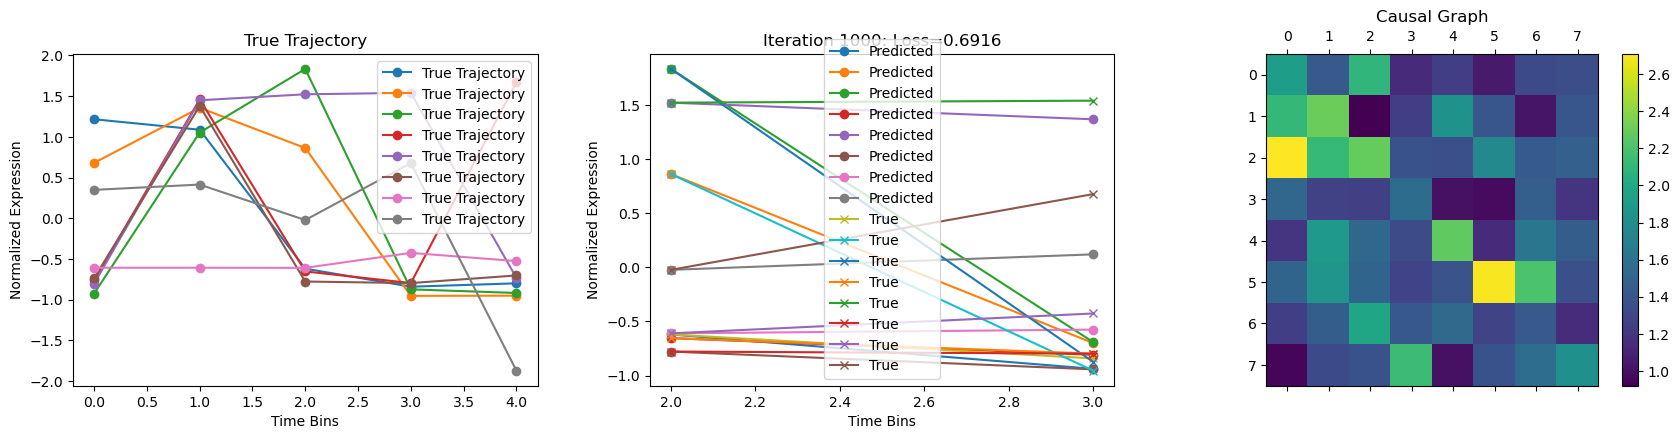

 20%|█▉        | 1999/10000 [06:35<24:59,  5.34it/s]  

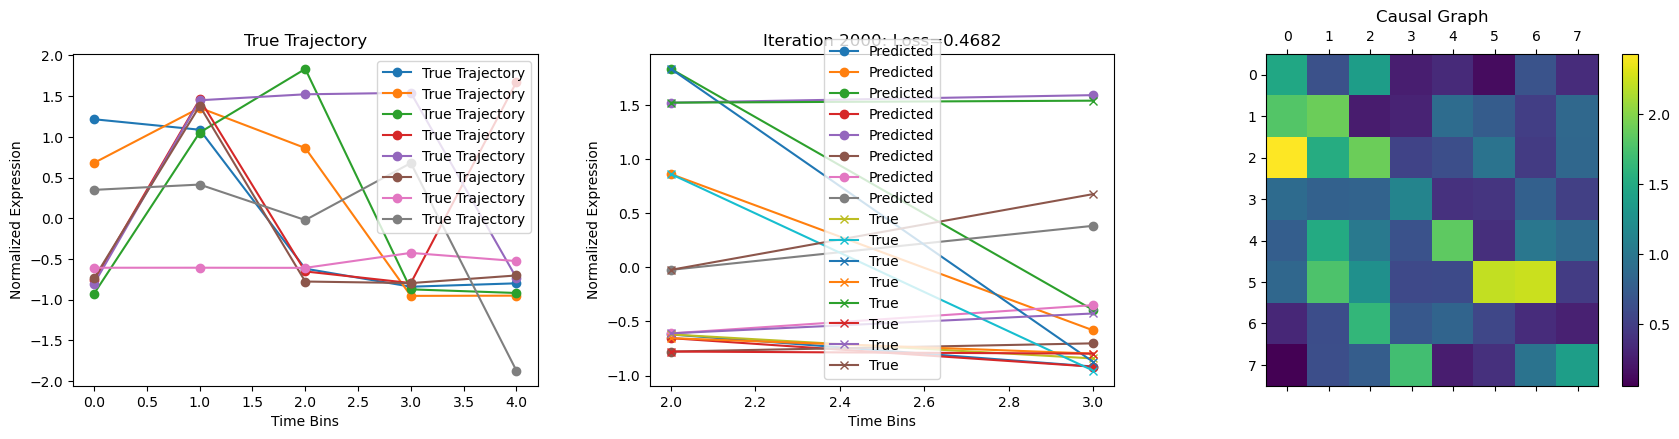

 30%|██▉       | 2999/10000 [09:24<16:56,  6.89it/s]

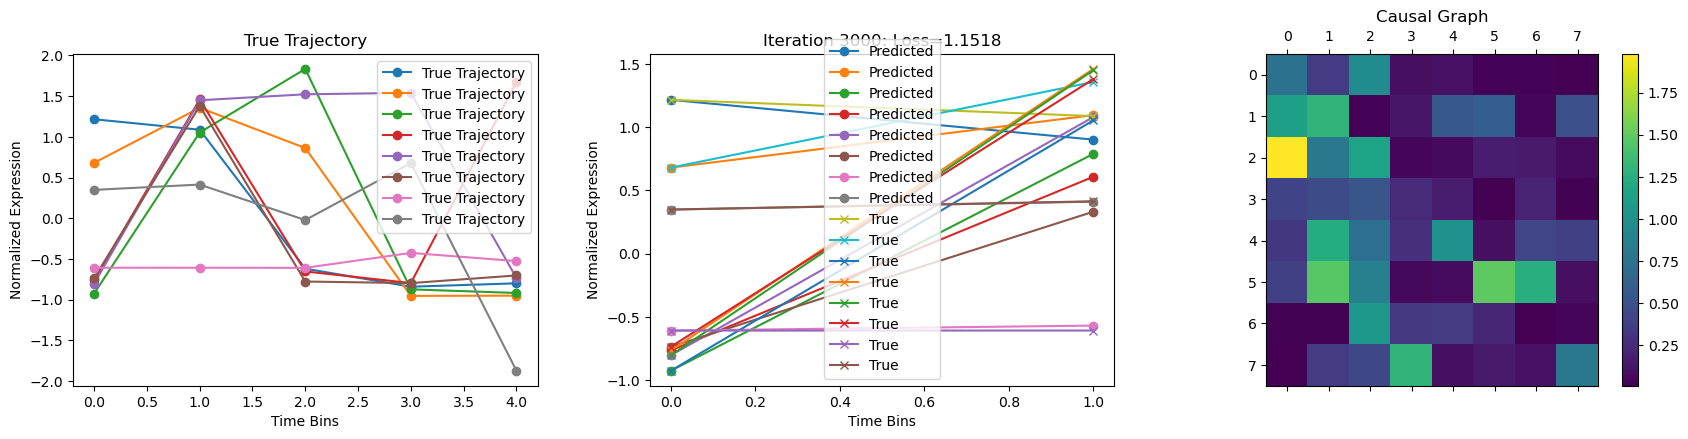

 40%|███▉      | 3999/10000 [12:18<15:11,  6.58it/s]

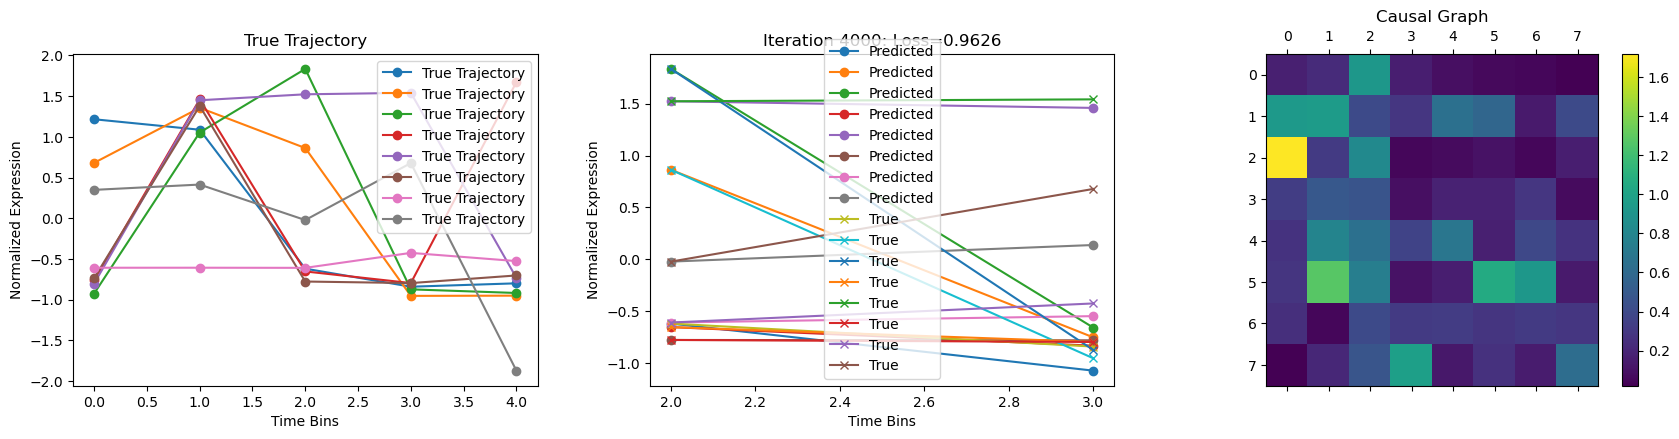

 50%|████▉     | 4999/10000 [14:49<13:16,  6.28it/s]

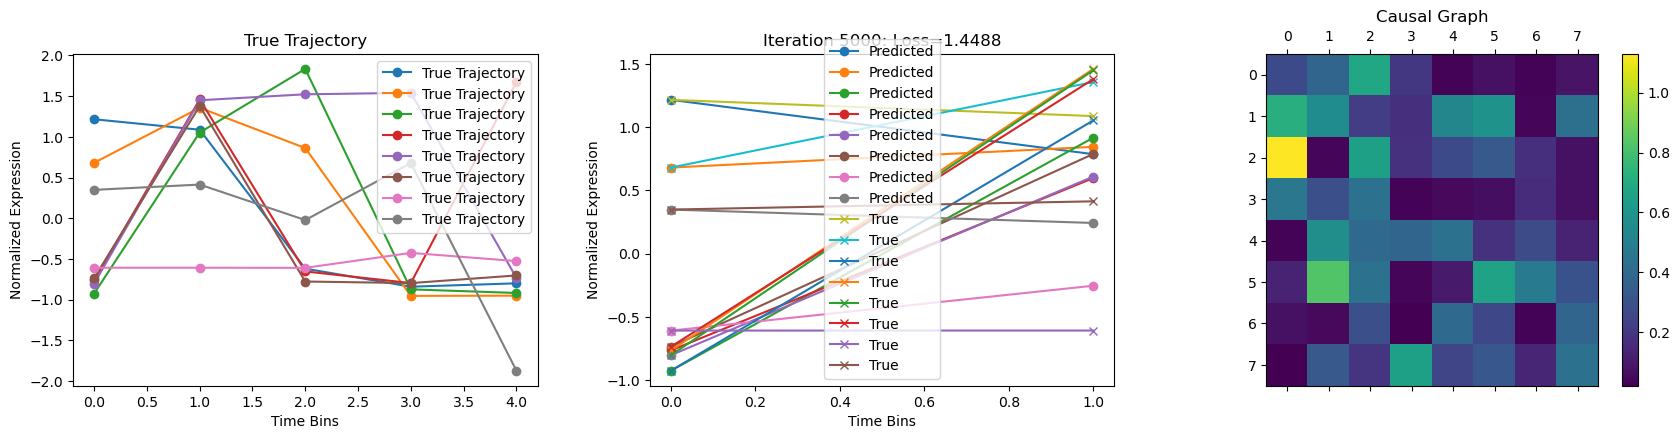

 60%|█████▉    | 5999/10000 [17:44<11:24,  5.85it/s]

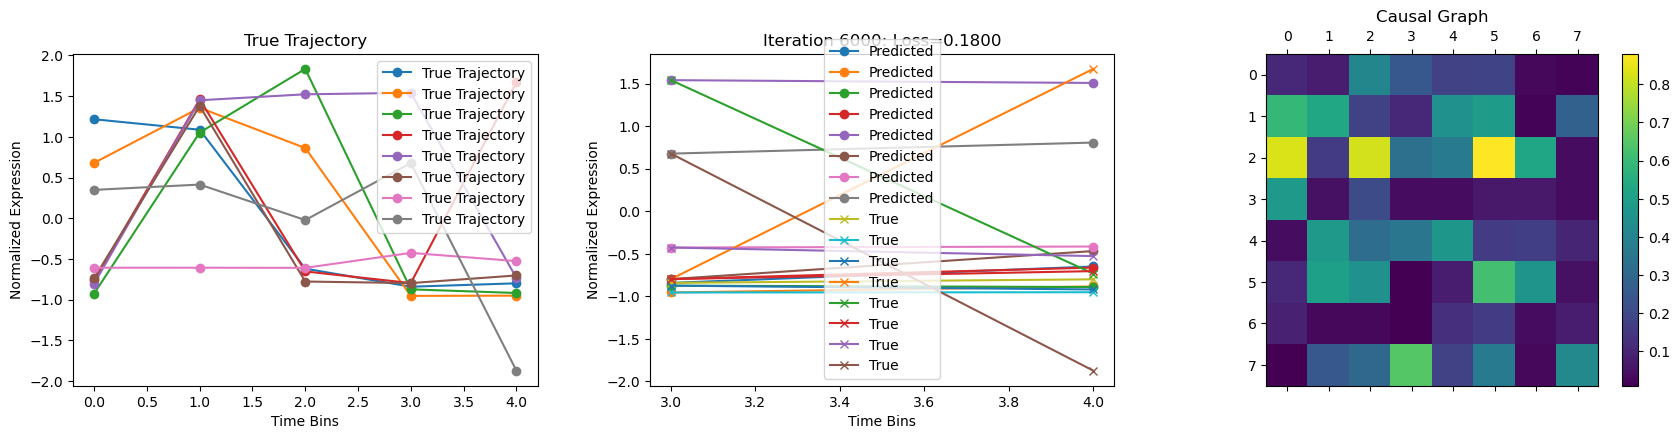

 70%|██████▉   | 6999/10000 [20:35<07:24,  6.76it/s]  

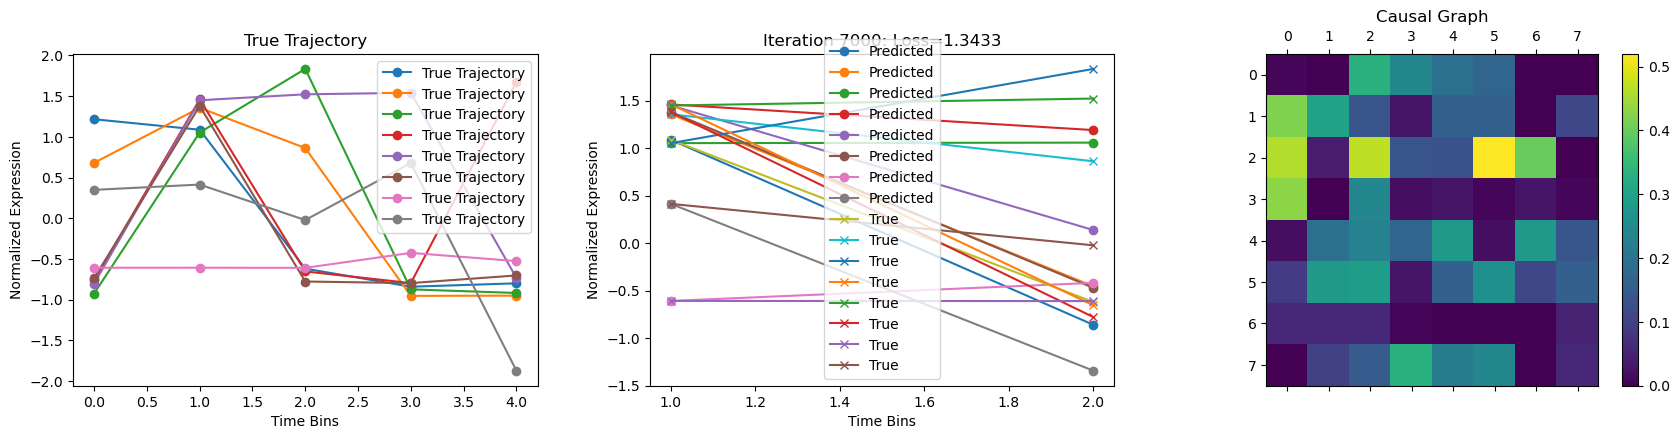

 80%|███████▉  | 7999/10000 [22:56<04:35,  7.27it/s]

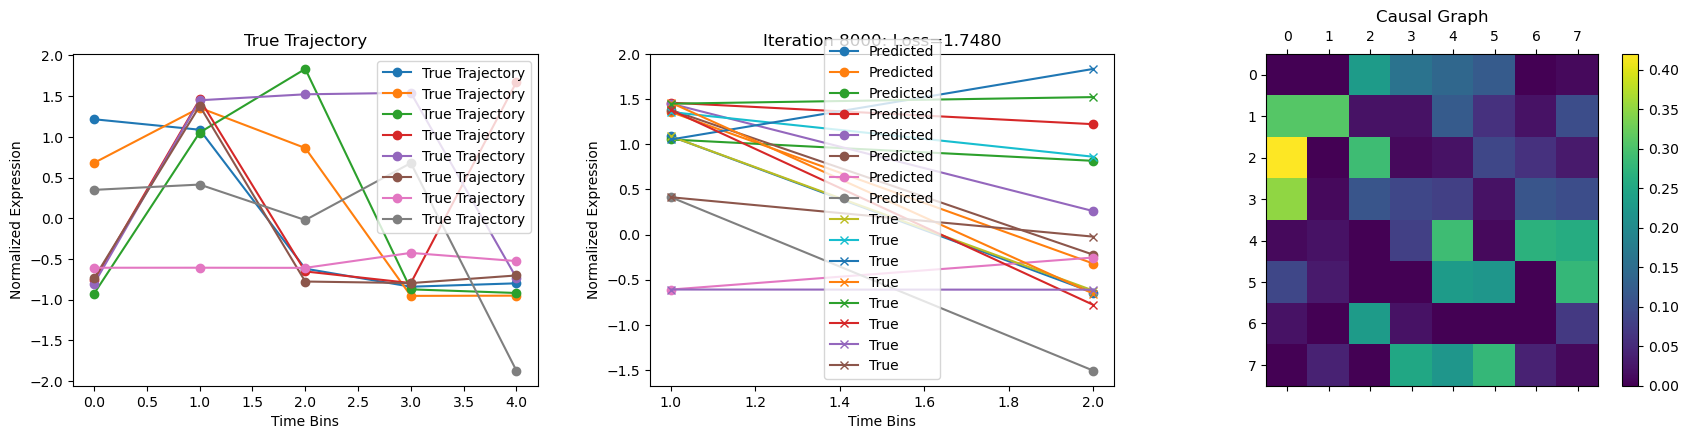

 90%|████████▉ | 8999/10000 [25:00<02:16,  7.31it/s]

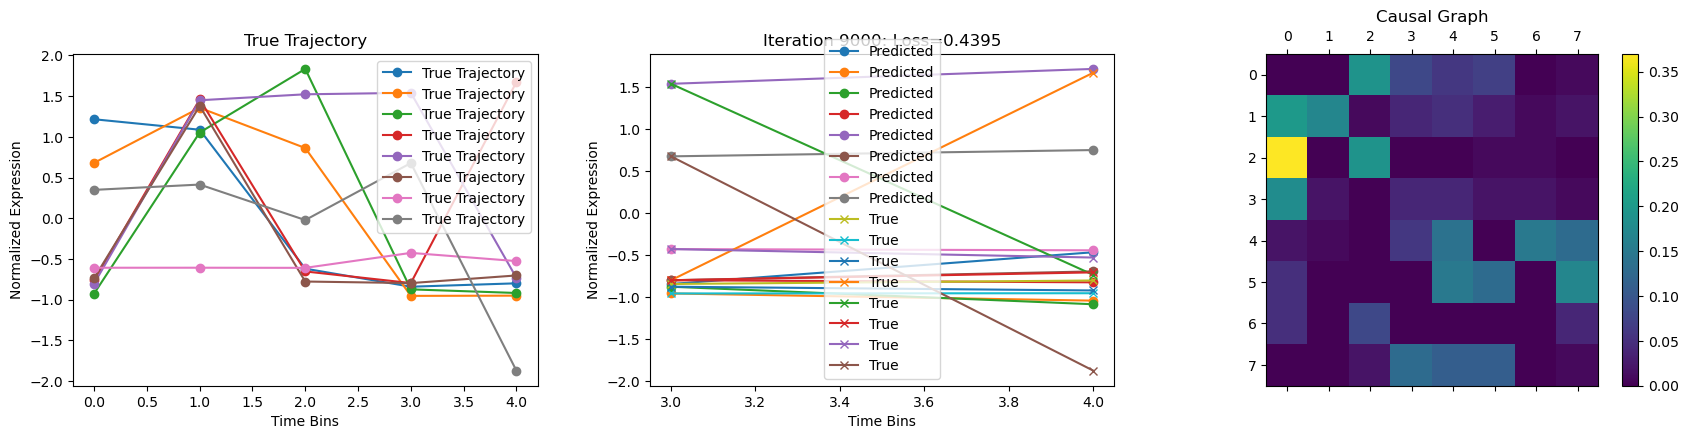

100%|█████████▉| 9999/10000 [26:44<00:00,  8.99it/s]

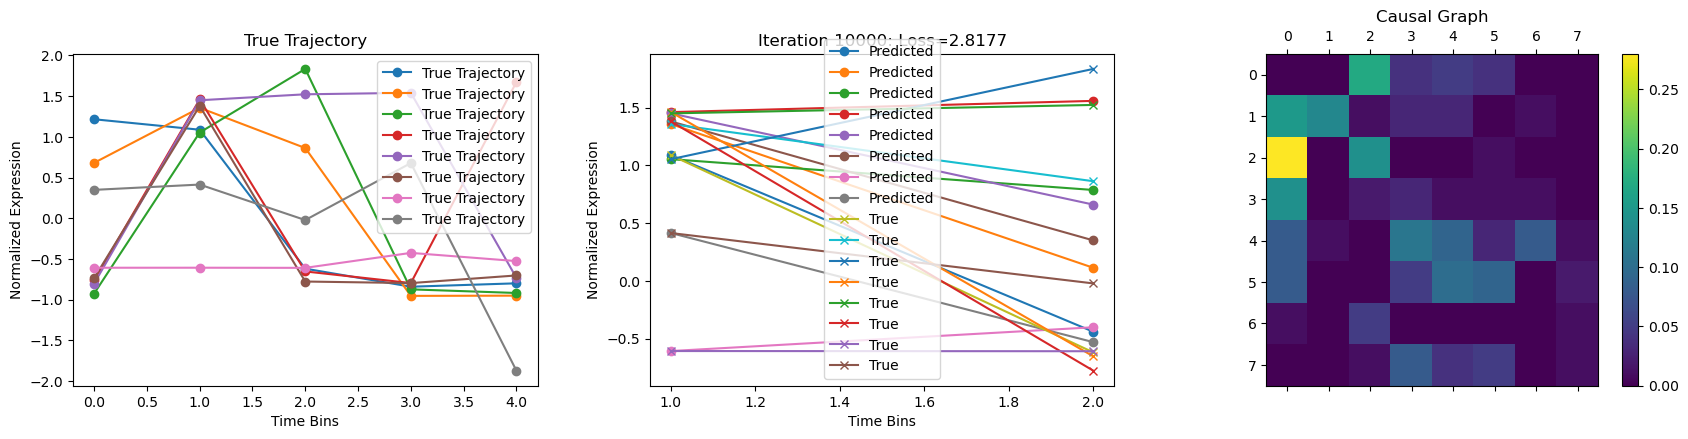

100%|██████████| 10000/10000 [26:45<00:00,  6.23it/s]


In [ ]:
importlib.reload(models)
num_variables = 8
hidden_dim = 200
dims = [num_variables, hidden_dim, 1]
func = models.MLPODEF(dims=dims, GL_reg=0.05)

wt_idx = [i for i, ko in enumerate(kos) if ko is None]
adatas_wt = [adatas[i] for i in wt_idx]
kos_wt = [kos[i] for i in wt_idx]
t = adatas[0].obs["t"].max()

# Prepare your data tensor
# Assuming you have loaded your data into 'adata' as a single AnnData object
grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

pis = compute_all_pis_fixed(adatas_wt[0], t, reg=1e-1)

# train_with_fixed_ot_plans(
#     func=func,
#     adatas=adatas_wt[0],
#     all_pis=pis,
#     t=t,
#     n_steps=5000,
#     batch_size=64,
#     device="cuda" if torch.cuda.is_available() else "cpu",
# )


# Train the model
train_sequential_discrete_time_ode(
    func=func,
    normalized_data=normalized_data,
    n_steps_per_transition=2500,  # Total steps = 2500 * 4 = 10000
    plot_freq=1000,
    l1_reg=0.0,
    l2_reg=0.0,
    plot=True,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

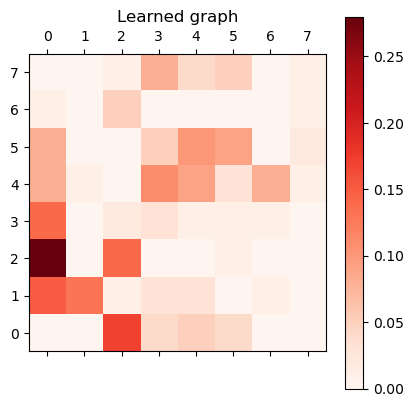

In [461]:
graph = func.causal_graph(w_threshold=0.0)
plt.matshow(graph, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

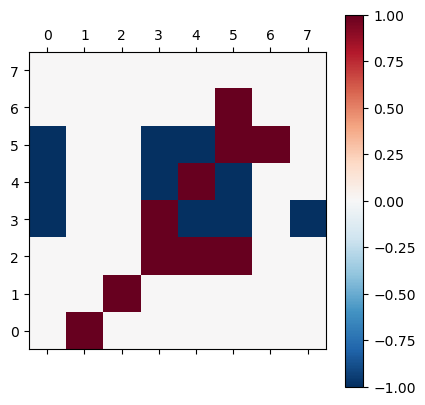

In [373]:
plt.matshow(data_loader.true_matrix, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Learned Graph')

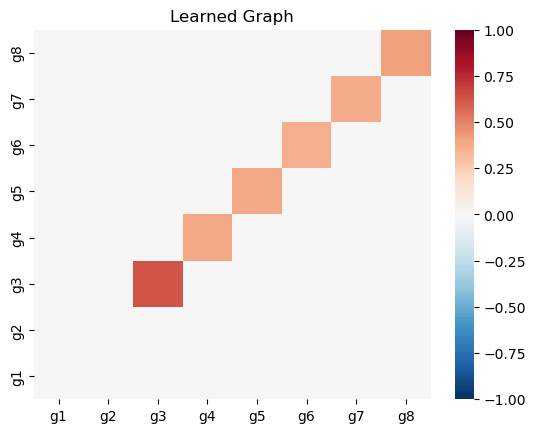

In [201]:
import seaborn as sns
gene_names = adatas[0].var_names

df_learned = pd.DataFrame(graph, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Learned Graph")

Text(0.5, 1.0, 'Real Graph')

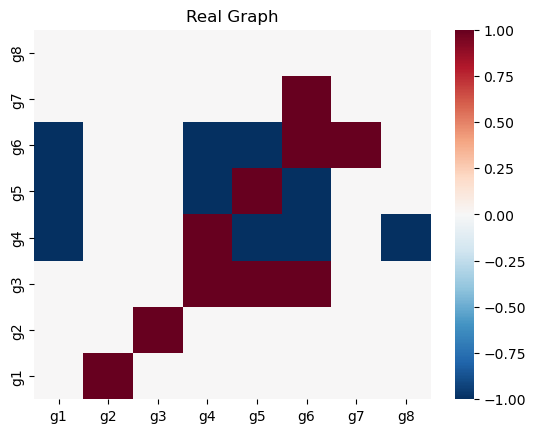

In [156]:
df_learned = pd.DataFrame(data_loader.true_matrix, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Real Graph")

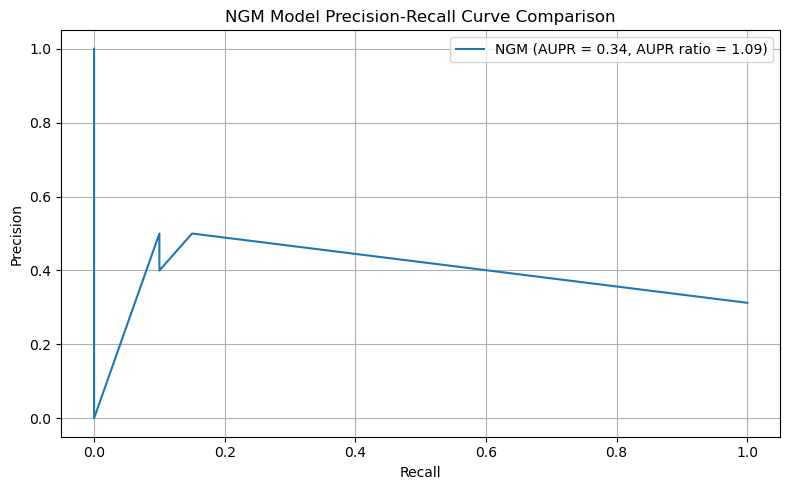

In [202]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def compare_models(learned_graph, true_matrix):
        """Compare the performance of NGM model with and without knockouts"""
        plt.figure(figsize=(8, 5))

        y_true = np.abs(np.sign(true_matrix).astype(int).flatten())

        models = [
            ("NGM", learned_graph)
        ]

        for name, predictions in models:
            prec, rec, _ = precision_recall_curve(y_true, np.abs(predictions.flatten()))
            avg_prec = average_precision_score(y_true, np.abs(predictions.flatten()))
            plt.plot(
                rec,
                prec,
                label=f"{name} (AUPR = {avg_prec:.2f}, "
                f"AUPR ratio = {avg_prec / y_true.mean():.2f})",
            )

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("NGM Model Precision-Recall Curve Comparison")
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
compare_models(graph, true_matrix)


# NGM with FM training

In [165]:
def sample_conditional_pt(x0, x1, t, sigma=0.01):
    """
    Samples points along the path from x0 to x1 based on time t.
    
    Args:
        x0 (torch.Tensor): Source points [batch_size, D]
        x1 (torch.Tensor): Target points [batch_size, D]
        t (torch.Tensor): Time scalar between 0 and 1 [batch_size]
        sigma (float): Noise level
    
    Returns:
        torch.Tensor: Sampled points [batch_size, D]
    """
    t = t.unsqueeze(-1)  # shape [batch_size, 1]
    x_tau = (1 - t) * x0 + t * x1 + sigma * torch.randn_like(x0)
    displacement = x1 - x0
    return x_tau, displacement

In [ ]:
from geomloss import SamplesLoss

In [455]:
def train_with_fmot(
    func,
    adatas,
    all_pis,
    t,     
    n_steps=2000,
    l2_reg=0.0,
    l1_reg=0.0,
    batch_size=64,
    device="cpu"
):
    def proximal(w, lam=0.1, eta=0.1):
            """Proximal step for group-lasso regularization."""
            # w shape [j * m1, i]
            wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
            tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
            alpha = torch.clamp(tmp, min=0)
            v = F.normalize(wadj, dim=1) * alpha[:, None, :]
            w.data = v.view(-1, func.dims[0])

    loss_history = []
    for step in tqdm(range(n_steps)):
        # Determine current transition
        optimizer = torch.optim.AdamW(func.parameters(), lr=1e-4)
        # time_bin = step % t
        time_bin = np.random.randint(0,t)
        pi_matrix = all_pis[time_bin]  # shape [n0, n1]
        if pi_matrix is None:
            continue
        
        # get cells in bin time_bin, time_bin+1
        cells_t0 = torch.from_numpy(adatas.X[adatas.obs["t"] == time_bin]).float()
        cells_t1 = torch.from_numpy(adatas.X[adatas.obs["t"] == time_bin + 1]).float()
        n0 = cells_t0.size(0)
        n1 = cells_t1.size(0)
        if n0==0 or n1==0:
            continue
        
        # sample x0 index
        idx0 = np.random.randint(n0, size=batch_size)
        x0 = cells_t0[idx0]
        
        # sample from row pi_matrix => distribution over cells_t1
        x1_list = []
        for row_i in idx0:
            row_pi = pi_matrix[row_i]
            row_pi = row_pi / row_pi.sum()
            choice = np.random.choice(n1, p=row_pi)
            x1_list.append(cells_t1[choice])
        x1 = torch.stack(x1_list, axis=0).to(device)  # shape [batch_size, d]

        # partial interpolation
        t_rand = torch.rand(batch_size, device=device)
        xt, ut = sample_conditional_pt(x0, x1, t_rand, sigma=0)


        x_tau_in = xt.unsqueeze(1)
        vt = func(time_bin, x_tau_in)
        vt = vt.squeeze(1)

        loss = torch.mean((vt - ut)**2)

        if l2_reg != 0:
            l2 = func.l2_reg()
            loss += l2_reg * l2
        if l1_reg != 0:
            l1 = func.fc1_reg()
            loss += l1_reg * l1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)

        loss_history.append(loss.item())

        if step % 1000 == 0:
            print(f"Step={step}, Loss={loss.item():.4f}")
            with torch.no_grad():
                graph = func.causal_graph(w_threshold=0.0)
                plt.matshow(graph, cmap="Reds")
                plt.gca().invert_yaxis()
                plt.colorbar()
                plt.title("Learned graph")
                plt.show()
                
    return loss_history, func

# Train random time points with fmot

In [445]:
def train_with_fmot_bins(
    func,
    adata,        
    all_pis,       
    t,             
    n_steps=2000,
    l2_reg=0.0,
    l1_reg=0.0,
    batch_size=64,
    device="cpu"
):
    
    def proximal(w, lam=0.1, eta=0.1):
        """Proximal step for group-lasso regularization."""
        # w shape [j * m1, i]
        wadj = w.view(func.dims[0], -1, func.dims[0])  # [d, hidden, d]
        tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, func.dims[0])

    optimizer = torch.optim.AdamW(func.parameters(), lr=1e-4)

    d = func.dims[0]  
    loss_history = []

    func.to(device)

    for step in tqdm(range(n_steps)):

        x0_list = []
        x1_list = []
        time_bin_list = []

        time_bins = np.random.randint(0, t, size=batch_size)  # each in [0..t-1]

        for j in range(batch_size):
            tb = time_bins[j]
            pi_matrix = all_pis[tb] 

            if pi_matrix is None:
                continue

            cells_t0 = adata.X[adata.obs["t"] == tb]
            cells_t1 = adata.X[adata.obs["t"] == tb + 1]
            n0 = cells_t0.shape[0]
            n1 = cells_t1.shape[0]
            if (n0 == 0) or (n1 == 0):
                continue

            row_i = np.random.randint(n0)

            row_pi = pi_matrix[row_i] 
            row_sum = row_pi.sum()
            if row_sum < 1e-12:
                choice = np.random.randint(n1)
            else:
                row_pi_norm = row_pi / row_sum
                choice = np.random.choice(n1, p=row_pi_norm)

            x0_j = torch.from_numpy(cells_t0[row_i]).float()
            x1_j = torch.from_numpy(cells_t1[choice]).float()

            x0_list.append(x0_j)
            x1_list.append(x1_j)
            time_bin_list.append(tb)

        valid_batch_size = len(x0_list)
        if valid_batch_size < 1:
            continue

        x0_t = torch.stack(x0_list, dim=0).to(device)
        x1_t = torch.stack(x1_list, dim=0).to(device)

        time_bin_tensor = torch.tensor(time_bin_list, dtype=torch.long, device=device)

        t_rand = torch.rand(valid_batch_size, device=device)
        xt, ut = sample_conditional_pt(x0_t, x1_t, t_rand, sigma=0.0)

        xt_in = xt.unsqueeze(1)                 
        vt = func(time_bin_tensor, xt_in)       
        vt = vt.squeeze(1)                      

        loss = torch.mean((vt - ut)**2)

        if l2_reg != 0.0:
            loss += l2_reg * func.l2_reg()
        if l1_reg != 0.0:
            loss += l1_reg * func.fc1_reg()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        proximal(func.fc1.weight, lam=func.GL_reg, eta=0.01)

        loss_history.append(loss.item())

        if step % 1000 == 0:
            print(f"Step={step}, Loss={loss.item():.4f}")

            with torch.no_grad():
                graph = func.causal_graph(w_threshold=0.0)
                plt.matshow(graph, cmap="Reds")
                plt.gca().invert_yaxis()
                plt.colorbar()
                plt.title("Learned graph")
                plt.show()

    return loss_history, func

In [ ]:
importlib.reload(models)

num_variables = 8
hidden_dim = 200
dims = [num_variables, hidden_dim, 1]
func = models.MLPODEF(dims=dims, GL_reg=0.01)

# beneficial to have plots - model fit, see if it can generate the same trajectories. 
# so plot PCA on wildtype, do simulation/inference with MLPODEF, at least 100 int steps, euler method, transform method, use pca transform of inferred data points
# do this for each marginal independently, check inference for each marginal pair (01), (1,2)

wt_idx = [i for i, ko in enumerate(kos) if ko is None]
adatas_wt = [adatas[i] for i in wt_idx]
kos_wt = [kos[i] for i in wt_idx]
t = adatas[0].obs["t"].max()

# Prepare your data tensor
# Assuming you have loaded your data into 'adata' as a single AnnData object
grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

pis = compute_all_pis_fixed(adatas_wt[0], t, reg=1e-1)

# train for models, each with a separate time bin
loss_history, func = train_with_fmot(
    func=func,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=t,
    l1_reg=0,
    l2_reg=0,
    n_steps=15000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

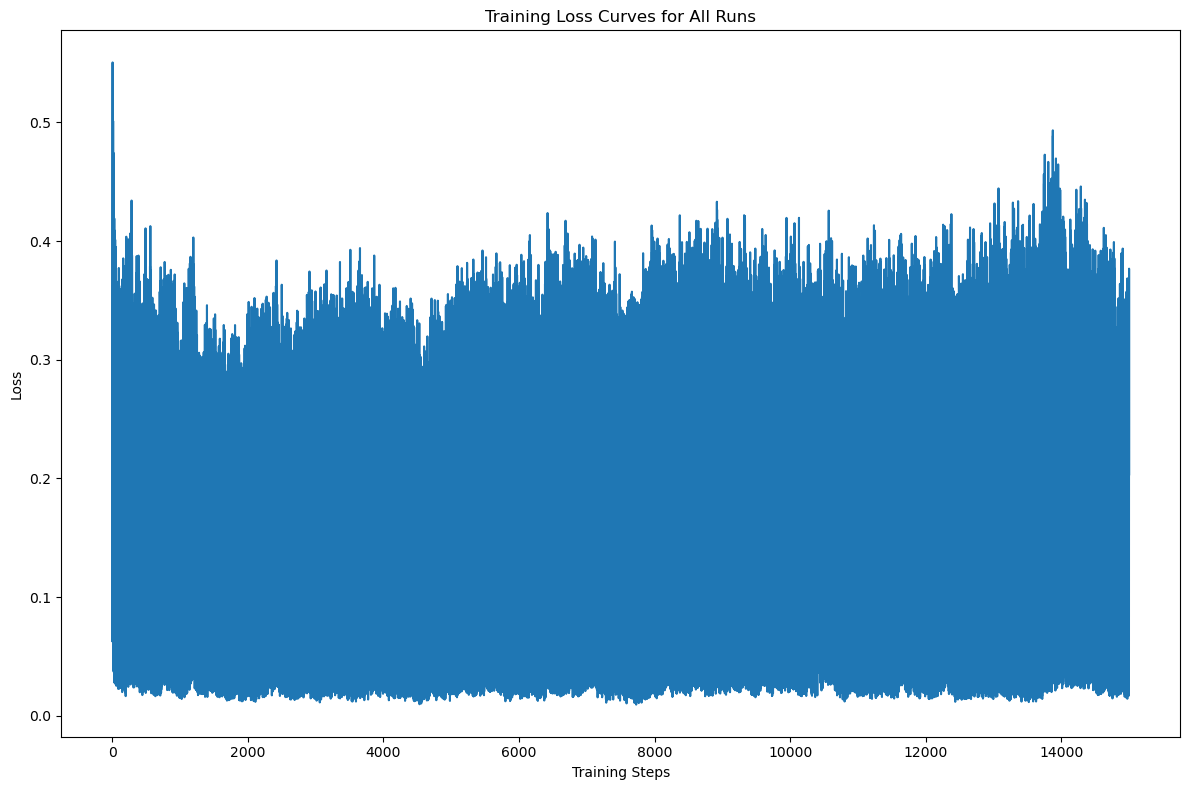

In [457]:
plt.figure(figsize=(12,8))
plt.plot(loss_history)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curves for All Runs")
plt.tight_layout()
plt.show()

In [29]:
graph = func.causal_graph(w_threshold=0.5)
plt.matshow(graph, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

NameError: name 'func' is not defined

Text(0.5, 1.0, 'Real Graph')

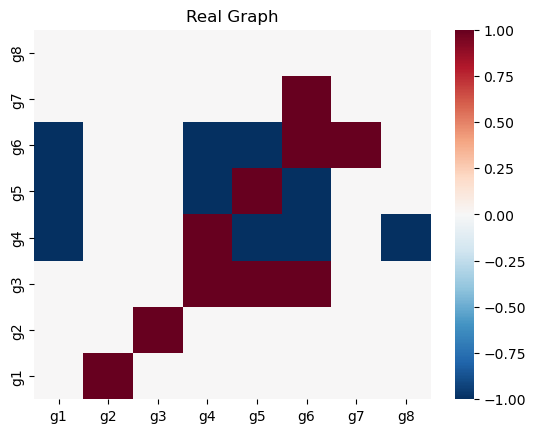

In [379]:
df_learned = pd.DataFrame(data_loader.true_matrix, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Real Graph")

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def compare_models(learned_graph, true_matrix):
        """Compare the performance of NGM model with and without knockouts"""
        plt.figure(figsize=(8, 5))

        y_true = np.abs(np.sign(true_matrix).astype(int).flatten())

        models = [
            ("NGM", learned_graph)
        ]

        for name, predictions in models:
            prec, rec, _ = precision_recall_curve(y_true, np.abs(predictions.flatten()))
            avg_prec = average_precision_score(y_true, np.abs(predictions.flatten()))
            plt.plot(
                rec,
                prec,
                label=f"{name} (AUPR = {avg_prec:.2f}, "
                f"AUPR ratio = {avg_prec / y_true.mean():.2f})",
            )

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("NGM Model Precision-Recall Curve Comparison")
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
compare_models(graph, true_matrix)

NameError: name 'graph' is not defined

# Train with FMOT plots and main

In [ ]:
importlib.reload(models)
num_variables = 8
hidden_dim = 200
dims = [num_variables, hidden_dim, 1]
func = models.MLPODEF(dims=dims, GL_reg=0.01)
func1 = models.MLPODEF(dims=dims, GL_reg=0.01)
func2 = models.MLPODEF(dims=dims, GL_reg=0.01)
func3 = models.MLPODEF(dims=dims, GL_reg=0.005)

# beneficial to have plots - model fit, see if it can generate the same trajectories. 
# so plot PCA on wildtype, do simulation/inference with MLPODEF, at least 100 int steps, euler method, transform method, use pca transform of inferred data points
# do this for each marginal independently, check inference for each marginal pair (01), (1,2)

wt_idx = [i for i, ko in enumerate(kos) if ko is None]
adatas_wt = [adatas[i] for i in wt_idx]
kos_wt = [kos[i] for i in wt_idx]
t = adatas[0].obs["t"].max()

grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)

pis = compute_all_pis_fixed(adatas_wt[0], t, reg=1e-1)

# train for models, each with a separate time bin
loss_history, func = train_with_fmot(
    func=func,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=0,
    n_steps=20000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

loss_history1, func1 = train_with_fmot(
    func=func1,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=1,
    n_steps=30000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

loss_history2, func2 = train_with_fmot(
    func=func2,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=2,
    n_steps=30000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

loss_history3, func3 = train_with_fmot(
    func=func3,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=3,
    n_steps=20000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
)





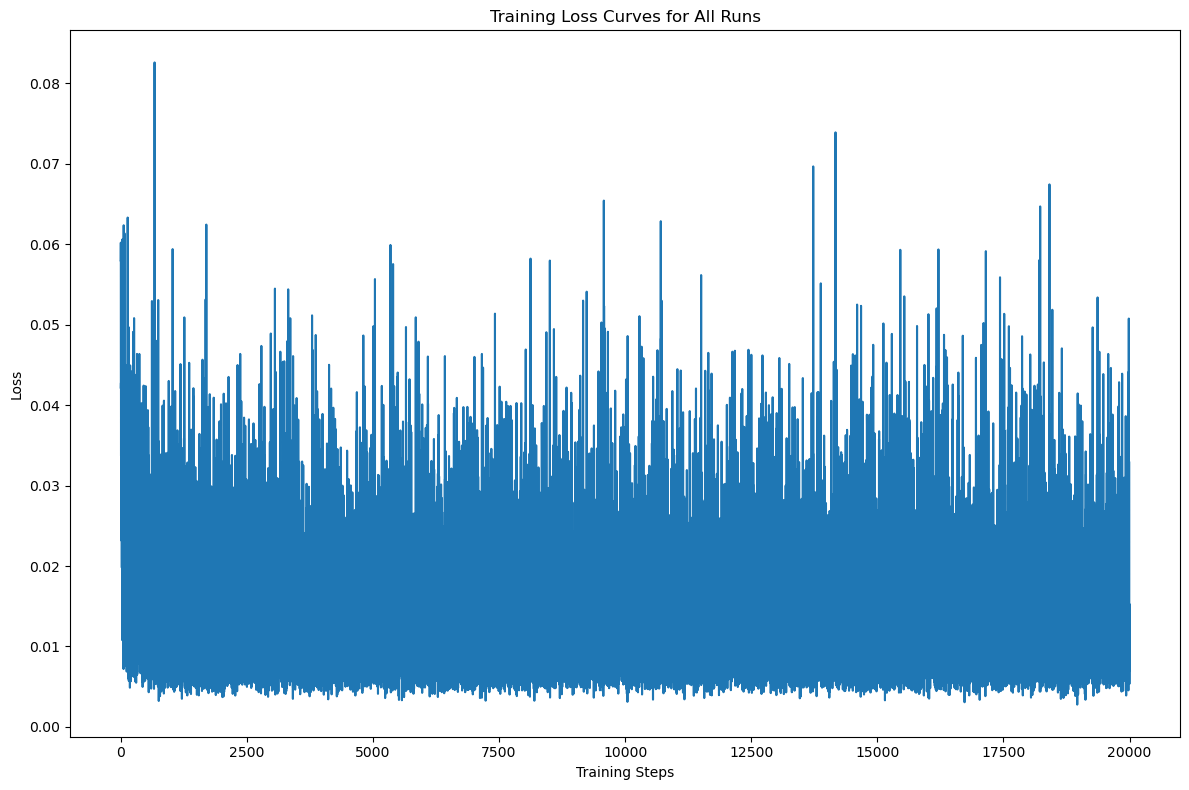

In [290]:
plt.figure(figsize=(12,8))
plt.plot(loss_history)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curves for All Runs")
plt.tight_layout()
plt.show()


In [ ]:
graph = func.causal_graph(w_threshold=0.)
plt.matshow(graph, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

In [350]:
def compare_models(learned_graph, true_matrix, ax):
    """Compare the performance of NGM model with and without knockouts"""
    y_true = np.abs(np.sign(true_matrix).astype(int).flatten())

    mods = [
        ("NGM", learned_graph)
    ]

    for name, predictions in mods:
        prec, rec, _ = precision_recall_curve(y_true, np.abs(predictions.flatten()))
        avg_prec = average_precision_score(y_true, np.abs(predictions.flatten()))
        ax.plot(
                rec,
                prec,
                label=f"{name} (AUPR = {avg_prec:.2f}, "
                f"AUPR ratio = {avg_prec / y_true.mean():.2f})",
            )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    ax.set_title("NGM Model Precision-Recall Curve Comparison")

    # def compare_models(learned_graph, true_matrix):
    #     """Compare the performance of NGM model with and without knockouts"""
    #     plt.figure(figsize=(8, 5))

    #     y_true = np.abs(np.sign(true_matrix).astype(int).flatten())

    #     models = [
    #         ("NGM", learned_graph)
    #     ]

    #     for name, predictions in models:
    #         prec, rec, _ = precision_recall_curve(y_true, np.abs(predictions.flatten()))
    #         avg_prec = average_precision_score(y_true, np.abs(predictions.flatten()))
    #         plt.plot(
    #             rec,
    #             prec,
    #             label=f"{name} (AUPR = {avg_prec:.2f}, "
    #             f"AUPR ratio = {avg_prec / y_true.mean():.2f})",
    #         )

    #     plt.xlabel("Recall")
    #     plt.ylabel("Precision")
    #     plt.title("NGM Model Precision-Recall Curve Comparison")
    #     plt.legend(loc="best")
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

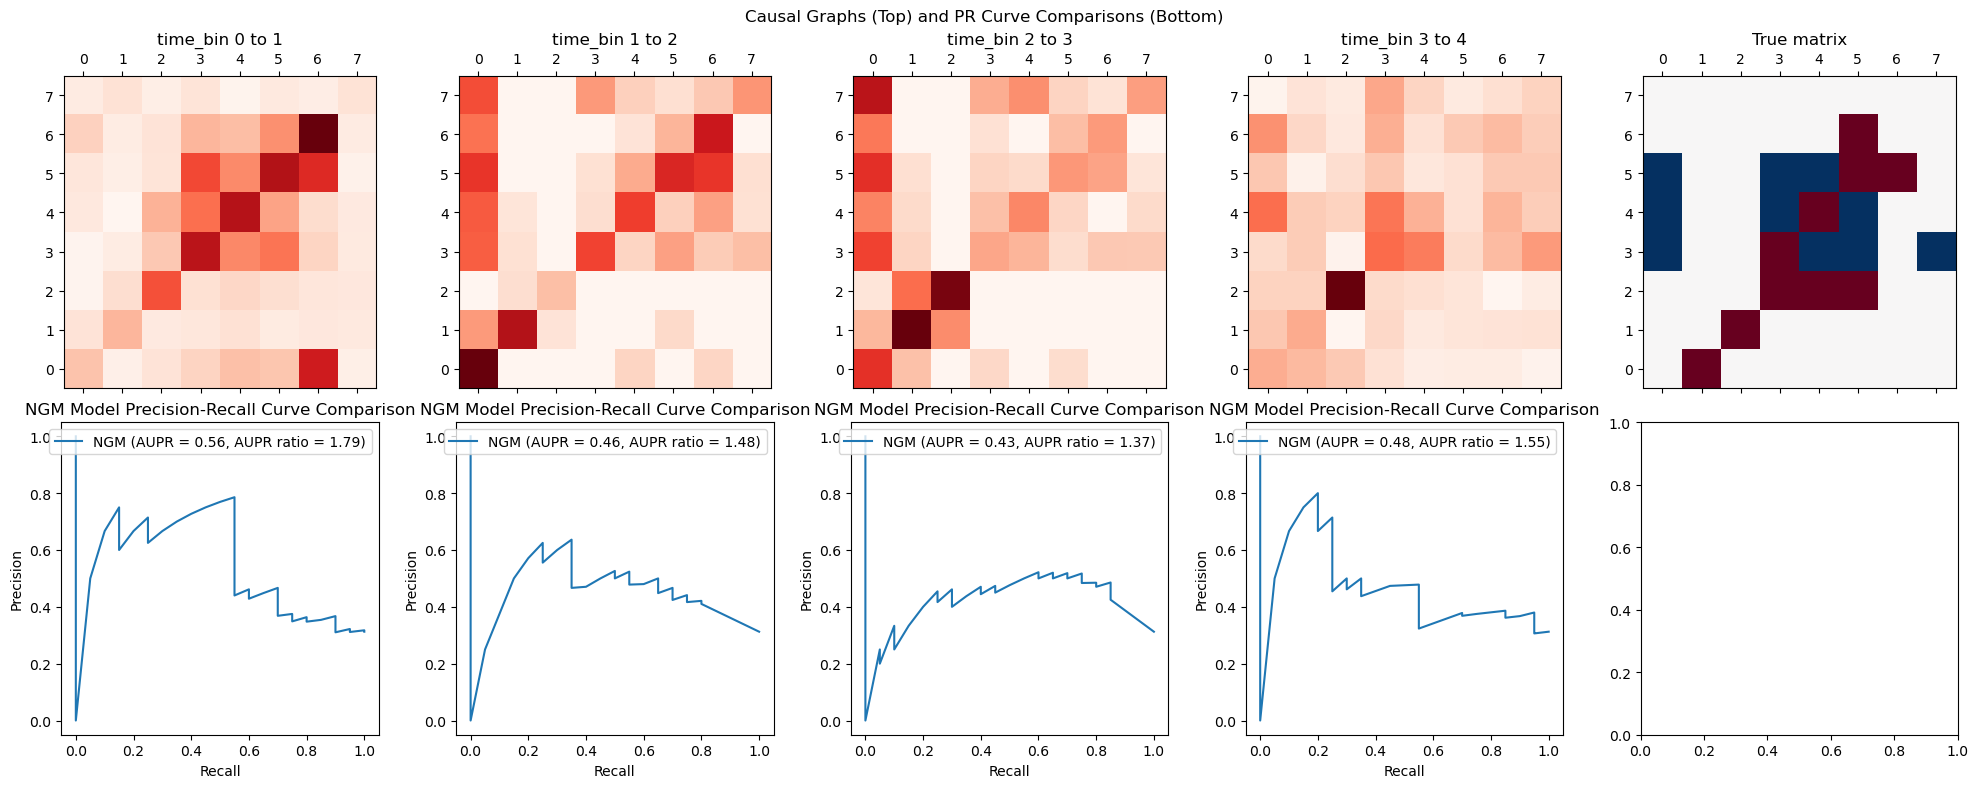

In [351]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
funcs = [func, func1, func2, func3]

for i, funct in enumerate(funcs):
    graph = funct.causal_graph(w_threshold=0.3)
    im = axes[0, i].matshow(graph, cmap="Reds")
    axes[0, i].invert_yaxis()
    axes[0, i].set_title(f"time_bin {i} to {i+1}")

im = axes[0, 4].matshow(data_loader.true_matrix, cmap="RdBu_r")
axes[0, 4].invert_yaxis()
axes[0, 4].set_title("True matrix")

for i, funct in enumerate(funcs):
    compare_models(funct.causal_graph(w_threshold=0.3), true_matrix, ax=axes[1,i])

fig.suptitle("Causal Graphs (Top) and PR Curve Comparisons (Bottom)")
fig.tight_layout()
plt.show()

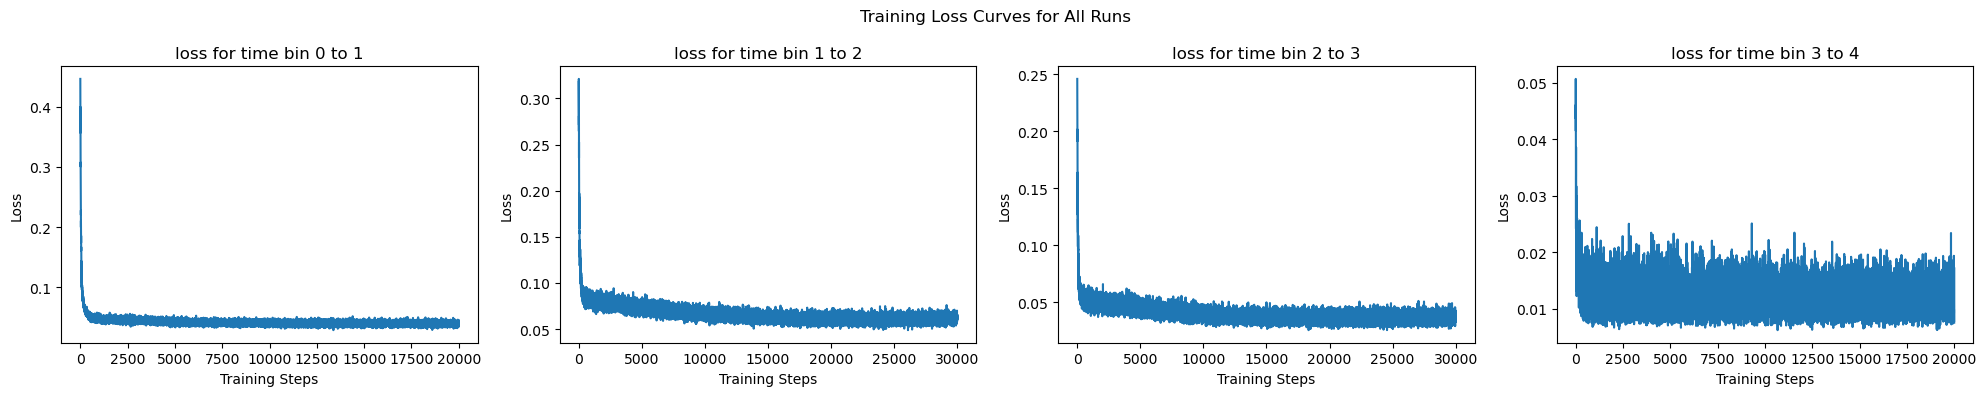

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
losses = [loss_history, loss_history1, loss_history2, loss_history3]

for i, loss in enumerate(losses):
    axes[i].plot(loss)  
    axes[i].set_xlabel("Training Steps")  
    axes[i].set_ylabel("Loss")
    axes[i].set_title(f"loss for time bin {i} to {i+1}")

fig.suptitle("Training Loss Curves for All Runs")
fig.tight_layout() 
plt.show()

In [ ]:
def plot_predicted_vs_true(func, adata, time_bin=0, n_samples=100, device="cpu"):
    """
    1) Randomly pick n_samples from adata in bin 'time_bin'
    2) ODE integrate from t=0..1 using the trained 'func'
    3) Compare final predicted to the actual data in bin time_bin+1
    4) Possibly do PCA or a scatter plot if dimension is large
    """
    # Get data from bin t
    cells_t0 = torch.from_numpy(adata.X[adata.obs["t"] == time_bin]).float()
    cells_t1 = torch.from_numpy(adata.X[adata.obs["t"] == time_bin + 1]).float()

    # If fewer than n_samples exist, clamp
    n0 = cells_t0.size(0)
    n_samples = min(n_samples, n0)
    idx = np.random.choice(n0, size=n_samples, replace=False)
    x0 = cells_t0[idx].to(device)

    # We'll do an ODE integration from times=[0.0, 1.0]
    times = torch.tensor([0.0, 1.0], device=device)
    x0_reshaped = x0.unsqueeze(1)  # => [n_samples,1,d]

    with torch.no_grad():
        z_pred = odeint(func, x0_reshaped, times)  # => shape [2, n_samples, 1, d]
    z_pred_final = z_pred[-1].squeeze(1).cpu().numpy()  # => [n_samples, d]

    # Now we also want the *actual* data from bin t+1 for the same *sampled indices*.
    # There's no direct 1-to-1 pairing in general, but let's at least pick 'n_samples' random from t+1
    # or we could do something else. For a direct correspond, you'd typically do OT matching,
    # but for a quick check, let's just random sample from bin(t+1) or compare distribution.
    n1 = cells_t1.size(0)
    idx_t1 = np.random.choice(n1, size=n_samples, replace=False)
    x1_np = cells_t1[idx_t1].numpy()

    # At this point:
    #   z_pred_final => [n_samples, d] predicted
    #   x1_np => [n_samples, d] "some random" actual points from bin(t+1)

    # Plot them in scatter form. If d>2, we can do a PCA transform:
    d = x0.shape[1]
    if d > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        # combine
        combined = np.vstack([z_pred_final, x1_np])
        combined_2d = pca.fit_transform(combined)
        pred_2d = combined_2d[:n_samples]
        true_2d = combined_2d[n_samples:]

        plt.figure(figsize=(6,6))
        plt.scatter(pred_2d[:,0], pred_2d[:,1], alpha=0.5, label="Predicted")
        plt.scatter(true_2d[:n_samples,0], true_2d[:n_samples,1], alpha=0.5, label="True bin t+1")
        plt.title(f"Time bin {time_bin}->{time_bin+1}, PCA (2D) comparison")
        plt.legend()
        plt.show()
    else:
        # If d=2, let's do direct scatter
        plt.figure(figsize=(6,6))
        plt.scatter(z_pred_final[:,0], z_pred_final[:,1], alpha=0.5, label="Predicted")
        plt.scatter(x1_np[:,0], x1_np[:,1], alpha=0.5, label="True bin t+1")
        plt.title(f"Time bin {time_bin}->{time_bin+1}, direct 2D scatter")
        plt.legend()
        plt.show()

In [344]:
try:
    from geomloss import SamplesLoss
    sinkhorn_loss = SamplesLoss("sinkhorn", p=2, blur=0.05)  
    HAS_GEOMLOSS = True
except ImportError:
    print("geomloss not found; skipping Wasserstein computation.")
    HAS_GEOMLOSS = False

def plot_predicted_vs_true_with_metrics(
    func,
    adata,
    time_bin=0,
    n_samples=100,
    device="cpu"
):

    cells_t0 = torch.from_numpy(adata.X[adata.obs["t"] == time_bin]).float()
    cells_t1 = torch.from_numpy(adata.X[adata.obs["t"] == time_bin + 1]).float()

    n0 = cells_t0.size(0)
    if n0 == 0:
        print(f"No data found for time_bin={time_bin}. Nothing to plot.")
        return

    n_samples = min(n_samples, n0)
    idx = np.random.choice(n0, size=n_samples, replace=False)
    x0 = cells_t0[idx].to(device)

    # We'll do an ODE integration from times=[0.0, 1.0]
    times = torch.tensor([0.0, 1.0], device=device)
    x0_reshaped = x0.unsqueeze(1)  # => [n_samples,1,d]

    with torch.no_grad():
        z_pred = odeint(func, x0_reshaped, times)  # => shape [2, n_samples, 1, d]
    z_pred_final = z_pred[-1].squeeze(1).cpu().numpy()  # => [n_samples, d]

    n1 = cells_t1.size(0)
    if n1 == 0:
        print(f"No data found for time_bin={time_bin+1}. Nothing to plot.")
        return
    idx_t1 = np.random.choice(n1, size=n_samples, replace=False)
    x1_np = cells_t1[idx_t1].numpy()

    d = x0.shape[1]
    if d > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)

        combined = np.vstack([z_pred_final, x1_np])
        combined_2d = pca.fit_transform(combined)
        pred_2d = combined_2d[:n_samples]
        true_2d = combined_2d[n_samples:]

        plt.figure(figsize=(6,6))
        plt.scatter(pred_2d[:,0], pred_2d[:,1], alpha=0.5, label="Predicted")
        plt.scatter(true_2d[:,0], true_2d[:,1], alpha=0.5, label="True bin t+1")
        plt.title(f"Time bin {time_bin}->{time_bin+1}, PCA (2D) comparison")
        plt.legend()
        plt.show()

    else:
        # If d=2, let's do direct scatter
        plt.figure(figsize=(6,6))
        plt.scatter(z_pred_final[:,0], z_pred_final[:,1], alpha=0.5, label="Predicted")
        plt.scatter(x1_np[:,0], x1_np[:,1], alpha=0.5, label="True bin t+1")
        plt.title(f"Time bin {time_bin}->{time_bin+1}, direct 2D scatter")
        plt.legend()
        plt.show()


    diff = z_pred_final - x1_np
    mse_val = np.mean(diff**2)

    pred_flat = z_pred_final.flatten()
    true_flat = x1_np.flatten()
    if pred_flat.std() < 1e-12 or true_flat.std() < 1e-12:
        corr_val = 0.0
    else:
        corr_val = np.corrcoef(pred_flat, true_flat)[0,1]

    true_mean = true_flat.mean()
    ss_res = np.sum((pred_flat - true_flat)**2)
    ss_tot = np.sum((true_flat - true_mean)**2) + 1e-12
    r2_val = 1.0 - ss_res/ss_tot

    if HAS_GEOMLOSS:
        z_pred_t = torch.from_numpy(z_pred_final).float().to(device)
        x1_t     = torch.from_numpy(x1_np).float().to(device)
        # sinkhorn_loss is fully differentiable, but we only do no-grad. We just want numeric
        with torch.no_grad():
            wass_val = sinkhorn_loss(z_pred_t, x1_t).item()
    else:
        wass_val = np.nan  # or 0.0

    metrics = [mse_val, corr_val, r2_val, wass_val]
    labels  = ["MSE", "Corr", "R^2", "Wass"]

    plt.figure(figsize=(5,4))
    plt.bar(range(len(metrics)), metrics, color=["skyblue","orange","green","red"])
    plt.xticks(range(len(metrics)), labels)
    plt.title(
        f"Metrics for bin {time_bin}->{time_bin+1}\n"
        f"MSE={mse_val:.3f}, Corr={corr_val:.3f}, R^2={r2_val:.3f}, Wass={wass_val:.3f}"
    )
    plt.ylim(bottom=min(0,min(metrics)-0.1))  # just to show bars from 0 or negative
    plt.show()

    print(f"Time bin {time_bin}->{time_bin+1}: "
          f"MSE={mse_val:.4f}, Corr={corr_val:.4f}, R^2={r2_val:.4f}, Wass={wass_val:.4f}")



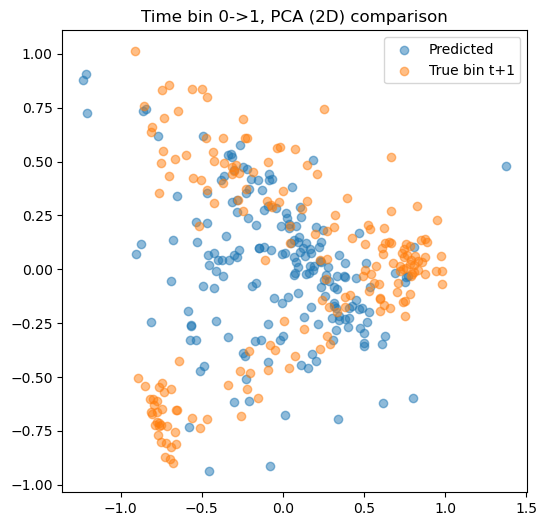

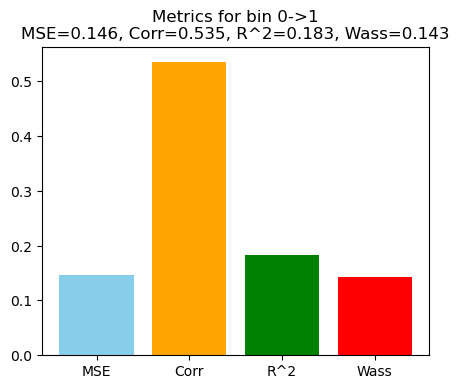

Time bin 0->1: MSE=0.1464, Corr=0.5354, R^2=0.1831, Wass=0.1430


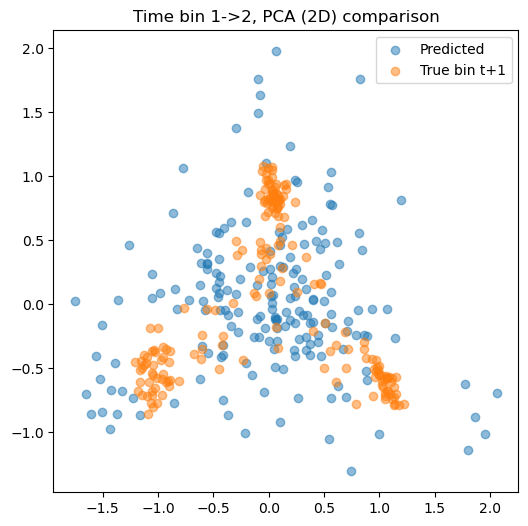

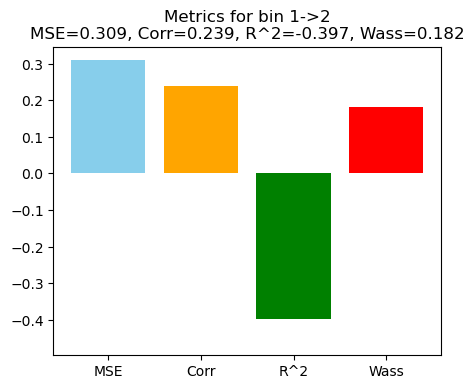

Time bin 1->2: MSE=0.3093, Corr=0.2390, R^2=-0.3971, Wass=0.1815


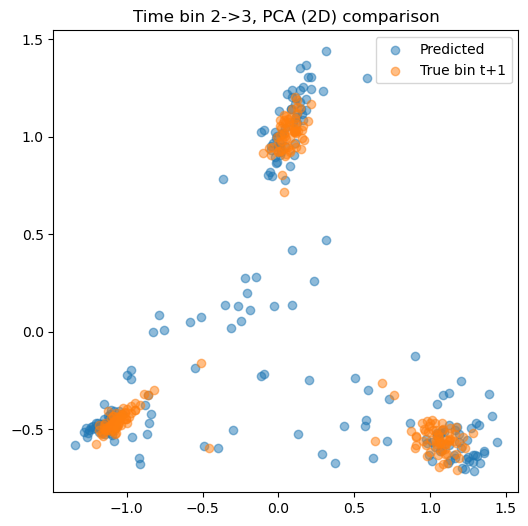

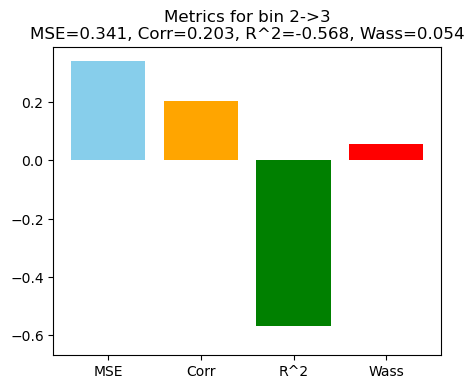

Time bin 2->3: MSE=0.3412, Corr=0.2026, R^2=-0.5679, Wass=0.0541


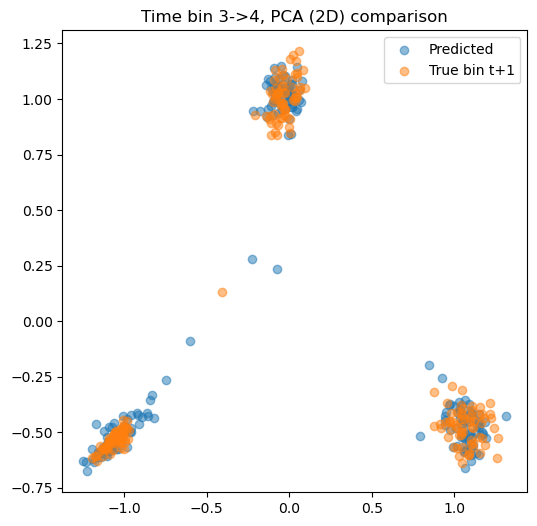

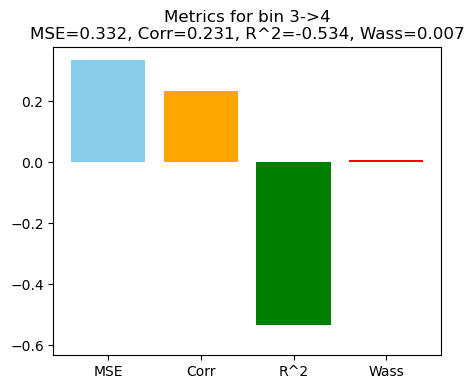

Time bin 3->4: MSE=0.3320, Corr=0.2312, R^2=-0.5341, Wass=0.0072


In [346]:
plot_predicted_vs_true_with_metrics(
    func=func,
    adata=adatas_wt[0],
    time_bin=0,
    n_samples=185,
    device="cpu"
)
plot_predicted_vs_true_with_metrics(
    func=func1,
    adata=adatas_wt[0],
    time_bin=1,
    n_samples=200,
    device="cpu"
)
plot_predicted_vs_true_with_metrics(
    func=func2,
    adata=adatas_wt[0],
    time_bin=2,
    n_samples=200,
    device="cpu"
)
plot_predicted_vs_true_with_metrics(
    func=func3,
    adata=adatas_wt[0],
    time_bin=3,
    n_samples=190,
    device="cpu"
)

Text(0.5, 1.0, 'Learned Graph')

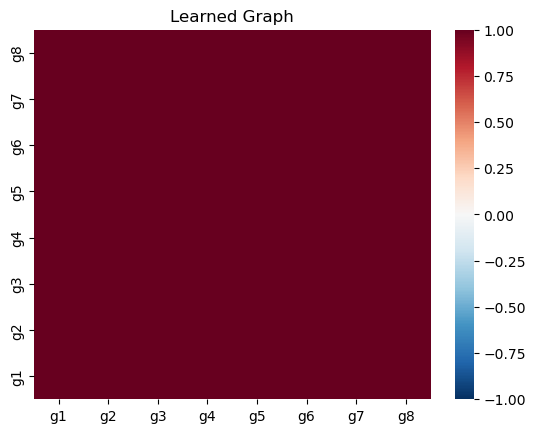

In [327]:
import seaborn as sns
gene_names = adatas[0].var_names

df_learned = pd.DataFrame(graph, index=gene_names, columns=gene_names)
sns.heatmap(df_learned, vmin=-1.0, vmax=1.0, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.title("Learned Graph")

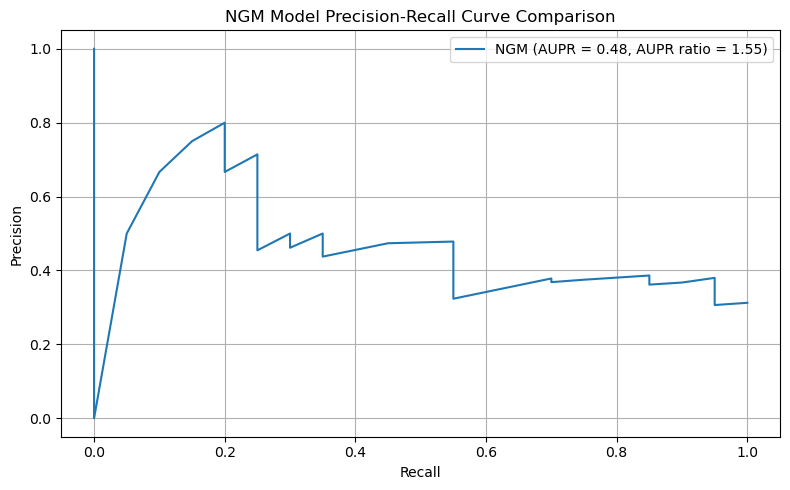

In [314]:
compare_models(graph, true_matrix)

# Define a Time Varying NGM

In [71]:
class TimeVaryingMLPODEFwithSeparateFC2(nn.Module):
    def __init__(self, dims, T=4, bias=True, GL_reg=0.01):
        super().__init__()
        assert len(dims) >= 2 and dims[-1] == 1

        self.dims = dims
        self.T = T
        self.GL_reg = GL_reg  # adaptive lasso parameter

        d_in = dims[0]      # number of genes
        d_hidden = dims[1]
        d_out = dims[-1]    # should be 1 for the delta of each gene

        # fc1_list => adjacency-layers
        self.fc1_list = nn.ModuleList([
            nn.Linear(d_in, d_in * d_hidden, bias=bias) for _ in range(T)
        ])

        # fc2_list => local transformations
        self.fc2_list = nn.ModuleList([
            nn.Linear(d_hidden, d_out, bias=bias) for _ in range(T)
        ])

        self.elu = nn.ELU(inplace=True)

    def forward(self, t_bins, x):
        batch_size, _, d = x.shape
        x = x.squeeze(1)  # => [batch_size, d]

        x_out = []
        for i in range(batch_size):
            bin_idx = t_bins[i].item()
            fc1 = self.fc1_list[bin_idx]
            fc2 = self.fc2_list[bin_idx]

            xi = x[i:i+1, :]           # shape [1, d]
            xi_out = fc1(xi)           # => shape [1, d*d_hidden]
            xi_out = xi_out.view(1, self.dims[0], self.dims[1])  # => [1, d, hidden]

            xi_out = self.elu(xi_out)
            # flatten => [d, hidden], apply fc2 => [d, 1]
            d_hidden_mat = xi_out.view(-1, self.dims[1])
            d_out_mat = fc2(d_hidden_mat)  # => [d, 1]

            # reshape => [1, d], then => [1, 1, d]
            d_out_mat = d_out_mat.view(1, self.dims[0], -1)  
            d_out_mat = d_out_mat.squeeze(-1).unsqueeze(0)

            x_out.append(d_out_mat)

        return torch.cat(x_out, dim=0)  # => [batch_size, 1, d]

    def adjacency_for_bin(self, bin_idx, threshold=0.0):
        """
        Return a [d, d] adjacency matrix for the given bin index,
        by reshaping fc1's weight and taking L2-norm across hidden dimension.
        """
        d = self.dims[0]
        d_hidden = self.dims[1]

        # shape [d*d_hidden, d]
        w = self.fc1_list[bin_idx].weight
        # => [d, d_hidden, d]
        w = w.view(d, d_hidden, d)
        # adjacency => L2-norm across hidden dimension => [d, d]
        W = torch.sqrt(torch.sum(w**2, dim=1))
        W = W.detach().cpu().numpy()

        if threshold > 0.0:
            W[W < threshold] = 0

        return W

    def aggregate_adjacency(self, mode='mean', threshold=0.0):
        """
        Aggregate adjacency from T bins into a single adjacency.
        mode can be 'mean', 'max', or 'final'.
        threshold is an optional cutoff for zeroing out small edges.
        """
        d = self.dims[0]
        # collect adjacency per bin
        adjacency_list = []
        for t in range(self.T):
            Wt = self.adjacency_for_bin(t, threshold=0.0)  # no threshold yet
            adjacency_list.append(Wt)

        if mode == 'mean':
            W_agg = np.mean(adjacency_list, axis=0)
        elif mode == 'max':
            W_agg = np.max(adjacency_list, axis=0)
        elif mode == 'final':
            W_agg = adjacency_list[-1]
        else:
            raise ValueError(f'Unknown mode={mode}')

        # optionally threshold after aggregation
        if threshold > 0.0:
            W_agg[np.abs(W_agg) < threshold] = 0.0

        return W_agg


In [97]:
def train_discrete_time_ngm(
    model,
    adatas,
    all_pis,
    T=4,
    n_steps=2000,
    batch_size=64,
    device="cpu"
):
    
    """
    A simplified training loop for a discrete-time model with T bins.
    - model is the updated TimeVaryingMLPODEFwithSeparateFC2
    - adata.obs['t'] in {0, 1, 2, 3}, so we do T-1 transitions
    - We'll do partial interpolation and match the direction (flow matching)
    """
    def proximal(w, lam=0.1, eta=0.1):
        """Proximal step for group-lasso regularization."""
        # w shape [j * m1, i]
        wadj = w.view(model.dims[0], -1, model.dims[0])  # [d, hidden, d]
        tmp = torch.sum(wadj**2, dim=1).pow(0.5) - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, model.dims[0])

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_history = []
    total_steps = n_steps * T

    for step in tqdm(range(1, total_steps + 1)):
        transition_idx = (step + 1) // n_steps

        # Current transition time bin
        tb = transition_idx
        pi_matrix = all_pis[tb]  # shape [n0, n1]
        if pi_matrix is None:
            continue
        
        # get cells in bin time_bin, time_bin+1
        cells_t0 = torch.from_numpy(adatas.X[adatas.obs["t"] == tb]).float()
        cells_t1 = torch.from_numpy(adatas.X[adatas.obs["t"] == tb + 1]).float()
        n0 = cells_t0.size(0)
        n1 = cells_t1.size(0)
        if n0==0 or n1==0:
            continue
        
        # sample x0 index
        idx0 = np.random.randint(n0, size=batch_size)
        x0 = cells_t0[idx0]
        
        # sample from row pi_matrix => distribution over cells_t1
        x1_list = []
        for row_i in idx0:
            row_pi = pi_matrix[row_i]
            row_pi = row_pi / row_pi.sum()
            choice = np.random.choice(n1, p=row_pi)
            x1_list.append(cells_t1[choice])
        x1 = torch.stack(x1_list, axis=0).to(device)  # shape [batch_size, d]

        # Partial interpolation factor
        t_rand = torch.rand(batch_size, 1, device=device)
        xt = (1 - t_rand)*x0 + t_rand*x1
        ut = (x1 - x0)

        time_bins = torch.full((batch_size,), tb, dtype=torch.long, device=device)
        xt_in = xt.unsqueeze(1)
        vt = model(time_bins, xt_in) 
        vt = vt.squeeze(1)           

        loss = F.mse_loss(vt, ut)

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        proximal(model.fc1_list[tb].weight, model.GL_reg)

        loss_history.append(loss.item())
        if step % 500 == 0:
            print(f"Step {step}, bin={tb}, Loss={loss.item():.4f}")
            graph = model.adjacency_for_bin(tb, threshold=0.0)
            plt.matshow(graph, cmap="Reds")
            plt.gca().invert_yaxis()
            plt.colorbar()
            plt.title("Learned graph")
            plt.show()


    return loss_history

  6%|▌         | 496/8000 [00:21<04:35, 27.26it/s]

Step 500, bin=0, Loss=0.0871


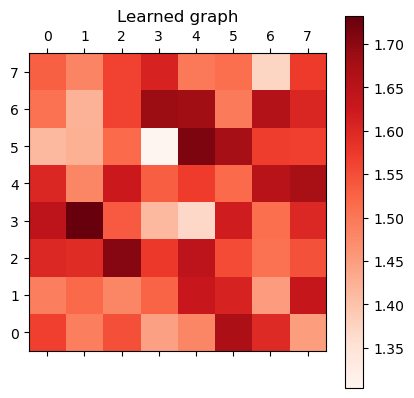

 12%|█▏        | 997/8000 [00:44<04:22, 26.66it/s]

Step 1000, bin=0, Loss=0.0671


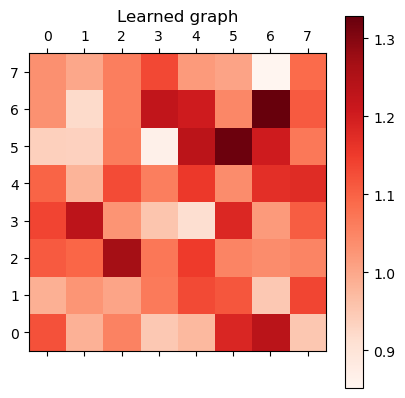

 19%|█▊        | 1499/8000 [01:08<04:56, 21.93it/s]

Step 1500, bin=0, Loss=0.0617


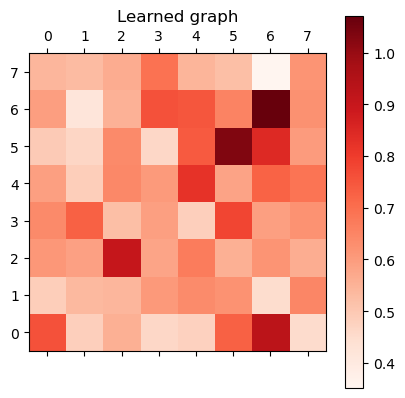

 25%|██▍       | 1998/8000 [01:30<04:11, 23.89it/s]

Step 2000, bin=1, Loss=0.3301


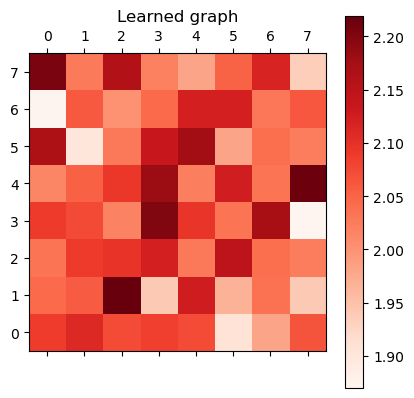

 31%|███       | 2498/8000 [01:54<04:20, 21.11it/s]

Step 2500, bin=1, Loss=0.1305


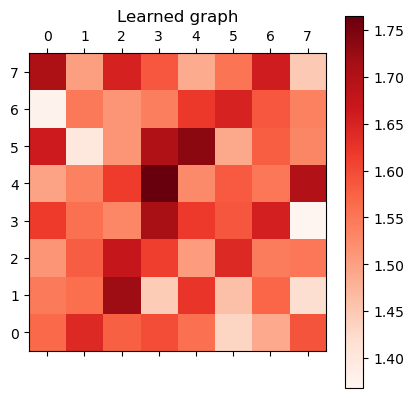

 37%|███▋      | 2996/8000 [02:19<03:03, 27.31it/s]

Step 3000, bin=1, Loss=0.0865


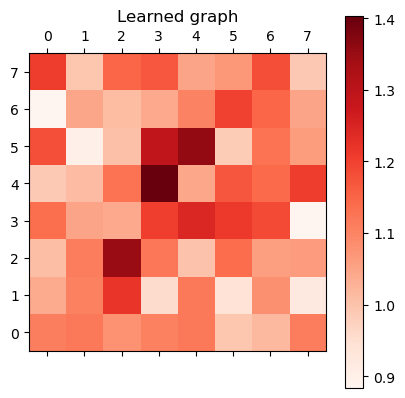

 44%|████▎     | 3497/8000 [02:43<03:14, 23.11it/s]

Step 3500, bin=1, Loss=0.0827


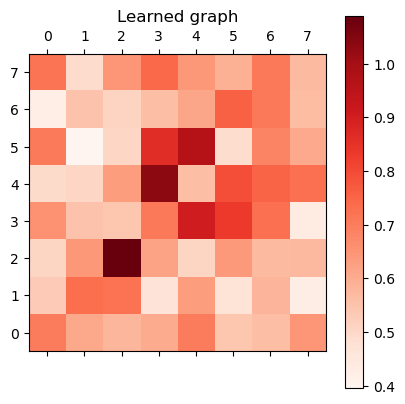

 50%|████▉     | 3998/8000 [03:06<02:26, 27.23it/s]

Step 4000, bin=2, Loss=0.2610


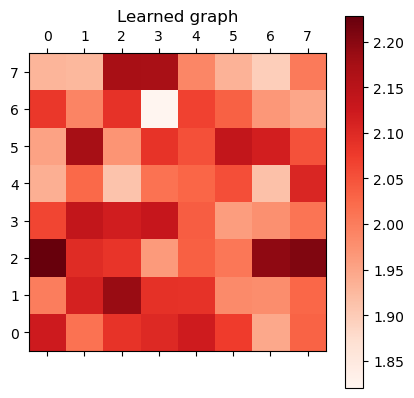

 56%|█████▌    | 4499/8000 [03:27<02:10, 26.77it/s]

Step 4500, bin=2, Loss=0.0596


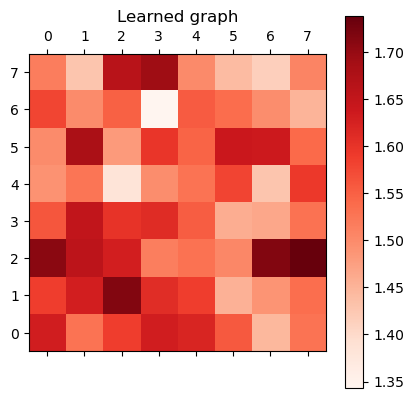

 62%|██████▏   | 4999/8000 [03:49<02:06, 23.75it/s]

Step 5000, bin=2, Loss=0.0549


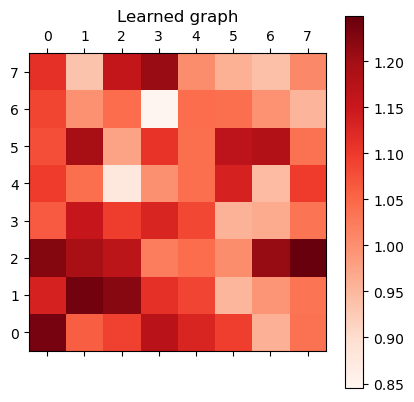

 69%|██████▊   | 5497/8000 [04:14<01:49, 22.91it/s]

Step 5500, bin=2, Loss=0.0587


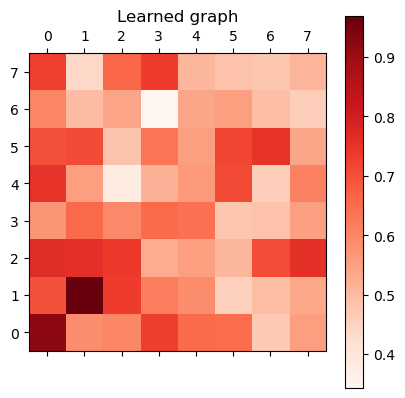

 75%|███████▍  | 5998/8000 [04:38<01:25, 23.49it/s]

Step 6000, bin=3, Loss=0.0864


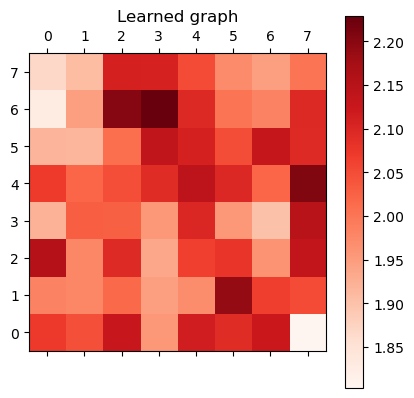

 81%|████████  | 6499/8000 [05:02<00:54, 27.66it/s]

Step 6500, bin=3, Loss=0.0171


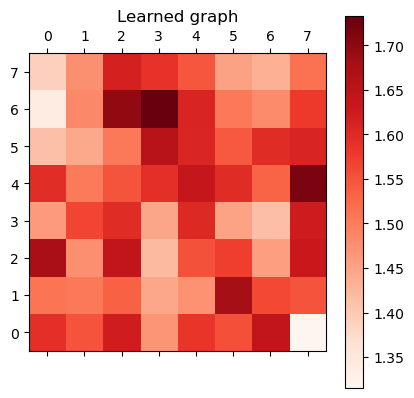

 87%|████████▋ | 6998/8000 [05:41<00:43, 23.24it/s]

Step 7000, bin=3, Loss=0.0087


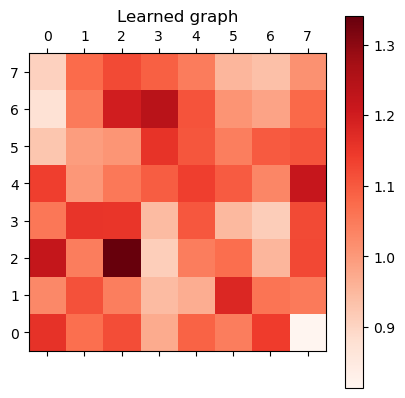

 94%|█████████▎| 7499/8000 [06:05<00:17, 27.90it/s]

Step 7500, bin=3, Loss=0.0131


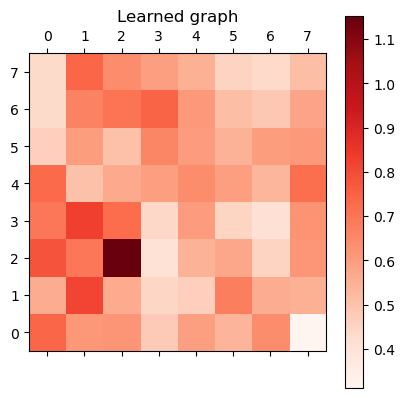

100%|█████████▉| 7999/8000 [06:32<00:00, 20.36it/s]


IndexError: list index out of range

In [96]:
model = TimeVaryingMLPODEFwithSeparateFC2(dims=[8, 100, 1], T=4, GL_reg=0.01)
t = adatas[0].obs["t"].max()
wt_idx = [i for i, ko in enumerate(kos) if ko is None]
adatas_wt = [adatas[i] for i in wt_idx]

pis = compute_all_pis_fixed(adatas_wt[0], t, reg=1e-1)  # all_pis


train_discrete_time_ngm(
    model,
    adatas_wt[0],
    all_pis=pis,
    T=4,
    n_steps=2000,
    batch_size=164,
    device="cpu"
)


In [100]:
W_agg_mean = model.aggregate_adjacency(mode='mean', threshold=0.2)

# or if you just want the final bin adjacency:
W_final = model.aggregate_adjacency(mode='final', threshold=0.3)

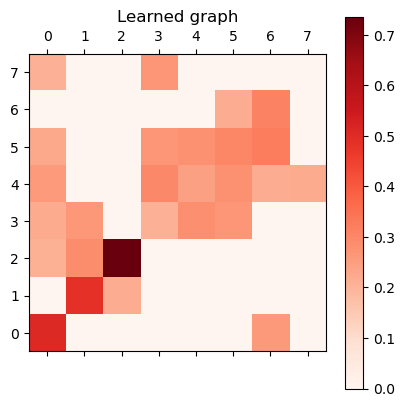

In [101]:
plt.matshow(W_agg_mean, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

In [102]:
print(true_matrix)

[[ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0  1  1  1  0  0]
 [-1  0  0  1 -1 -1  0 -1]
 [-1  0  0 -1  1 -1  0  0]
 [-1  0  0 -1 -1  1  1  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [103]:
print(W_agg_mean * (1-np.eye(8)))

[[0.         0.         0.         0.         0.         0.
  0.26039833 0.        ]
 [0.         0.         0.21729533 0.         0.         0.
  0.         0.        ]
 [0.20816416 0.28729308 0.         0.         0.         0.
  0.         0.        ]
 [0.21918231 0.26230133 0.         0.         0.28424636 0.26736012
  0.         0.        ]
 [0.25692084 0.         0.         0.29838428 0.         0.27604654
  0.21679345 0.21874079]
 [0.22525141 0.         0.         0.26536071 0.27732801 0.
  0.32215911 0.        ]
 [0.         0.         0.         0.         0.         0.21495779
  0.         0.        ]
 [0.20659965 0.         0.         0.26707435 0.         0.
  0.         0.        ]]


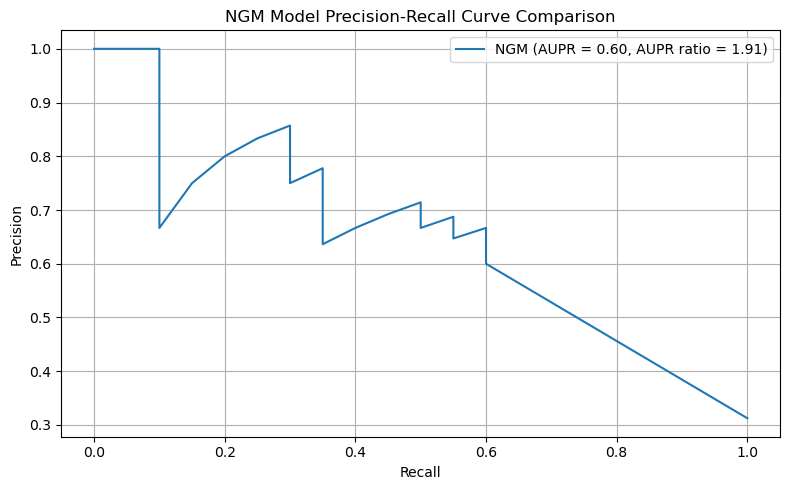

In [104]:
compare_models((W_agg_mean*(1-np.eye(8))), true_matrix)

# More experiments

In [11]:
def sample_map(pi, batch_size, replace=True):
    """
    Randomly pick (i, j) from the coupling matrix pi (shape [n0, n1]).
    Returns arrays of row indices i and column indices j.
    """
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(len(p), size=batch_size, replace=replace, p=p)
    i = choices // pi.shape[1]
    j = choices % pi.shape[1]
    return i, j


def sample_plan(x0, x1, pi, batch_size, device='cpu'):
    """
    Given x0 in [n0, d], x1 in [n1, d], and pi in [n0, n1],
    sample a batch of (x0, x1) pairs according to pi.
    """
    i, j = sample_map(pi, batch_size)
    return torch.tensor(x0[i], dtype=torch.float32, device=device), \
           torch.tensor(x1[j], dtype=torch.float32, device=device)


def brownian_bridge(x0, x1, tau, sigma=0.1):
    """
    Construct a Brownian bridge from x0->x1 at fraction tau in [0,1].
    x0, x1: shape [batch_size, d]
    tau: shape [batch_size, 1]
    sigma: noise scale
    """
    mean_ = (1 - tau)*x0 + tau*x1
    var_ = (sigma**2) * tau * (1 - tau)
    # sample x(tau) = mean + sqrt(var)*epsilon
    eps = torch.randn_like(x0)
    x_tau = mean_ + torch.sqrt(var_.clamp_min(1e-10)) * eps

    # bridging score: s = -(x - mean)/var
    s_true = -(x_tau - mean_) / var_.clamp_min(1e-10)
    
    denom = 2 * tau * (1 - tau) + 1e-10
    u = ((1 - 2*tau) / denom) * (x_tau - mean_) + (x1 - x0)
    return x_tau, s_true, u


In [24]:
def train_with_fmot_scorematching(
    func_v,          
    func_s,           
    adatas,           
    all_pis,          
    t,                
    sigma=0.1,        
    dt=1.0,           
    alpha=0.5,        
    reg=1e-5,         
    n_steps=2000,
    batch_size=64,
    device="cpu",
    lr=1e-3
):
    """
    Combine flow matching + score matching
    """
    func_v.to(device)
    func_s.to(device)
    optimizer = torch.optim.AdamW(
        list(func_v.parameters()) + list(func_s.parameters()), lr=lr)

    loss_history = []
    def proximal(w, dims, lam=0.1, eta=0.01):
        with torch.no_grad():
            d = dims[0]
            d_hidden = dims[1]
            wadj = w.view(d, d_hidden, d)  # => [d, hidden, d]
            tmp = torch.sum(wadj**2, dim=1).sqrt() - lam * eta
            alpha_ = torch.clamp(tmp, min=0)
            v_ = F.normalize(wadj, dim=1) * alpha_[:, None, :]
            w.copy_(v_.view(-1, d))

    for step in tqdm(range(n_steps)):
        tb = np.random.randint(0, t)
        
        pi_matrix = all_pis[tb]
        if pi_matrix is None:
            continue

        cells_t0 = adatas.X[(adatas.obs["t"] == tb).values, :]
        cells_t1 = adatas.X[(adatas.obs["t"] == tb + 1).values, :]
        n0, n1 = cells_t0.shape[0], cells_t1.shape[0]
        if n0 == 0 or n1 == 0:
            continue
        
        x0, x1 = sample_plan(cells_t0, cells_t1, pi_matrix, batch_size, device=device)

        tau = torch.rand(batch_size, 1, device=device)
        
        # build bridging => x(tau), s_true, u
        x_tau, s_true, u = brownian_bridge(x0, x1, tau, sigma=sigma)
        
        v_input = x_tau.unsqueeze(1) 
        v_pred  = func_v(tb, v_input) 
        v_pred  = v_pred.squeeze(1) 

        s_input = x_tau              
        B = s_input.shape[0]
        t_tensor = torch.full((B,), float(tb), device=device)

        s_pred = func_s(t_tensor, s_input)

        weight_ = tau * (1 - tau)
        L_score = torch.mean(weight_ * (s_pred - s_true)**2)

        L_flow = torch.mean((v_pred * dt - u)**2)

        L_reg = 0.0
        if hasattr(func_v, "l2_reg"):
            L_reg += func_v.l2_reg()
        if hasattr(func_v, "fc1_reg"):
            L_reg += func_v.fc1_reg()
        
        L = alpha*L_score + (1 - alpha)*L_flow + reg*L_reg

        optimizer.zero_grad()
        L.backward()
        optimizer.step()

        if hasattr(func_v, "fc1") and hasattr(func_v, "dims"):
            proximal(func_v.fc1.weight, func_v.dims, lam=func_v.GL_reg, eta=0.01)
        

        loss_history.append(L.item())
        if step % 1000 == 0:
            print(f"Step={step}, tb={tb}, L_score={L_score.item():.4f}, L_flow={L_flow.item():.4f}, L_reg={L_reg:.4f}")

    plt.plot(loss_history)
    plt.title("Score+Flow Matching Loss")
    plt.xlabel("training step")
    plt.ylabel("loss")
    plt.show()

    return loss_history, func_v, func_s


In [13]:
import copy

class MLP(nn.Module):
    def __init__(self, d = 2, hidden_sizes = [100, ], activation = nn.ReLU, time_varying = True):
        super(MLP, self).__init__()
        self.net = nn.Sequential()
        self.time_varying = time_varying 
        assert len(hidden_sizes) > 0
        hidden_sizes = copy.copy(hidden_sizes)
        if time_varying:
            hidden_sizes.insert(0, d+1)
        else:
            hidden_sizes.insert(0, d)
        hidden_sizes.append(d)
        for i in range(len(hidden_sizes)-1):
            self.net.add_module(name = f"L{i}", module = nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if i < len(hidden_sizes)-2:
                self.net.add_module(name = f"A{i}", module = activation())
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.normal_(m.bias, mean=0, std=0)
    def forward(self, t, x):
        if self.time_varying:
            if t.dim() == 1:
                t = t.unsqueeze(-1)

            inp = torch.cat([x, t], dim=1)
            return self.net(inp)
        else:
            return self.net(x)


/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 663
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:499: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/noah/miniconda3/envs/comp550/lib/python3.11/site-packages/ot/bregman/_s

Step=0, tb=2, L_score=102.7142, L_flow=0.5600, L_reg=2812.9817


  7%|▋         | 1024/15000 [00:08<02:12, 105.56it/s]

Step=1000, tb=2, L_score=91.7915, L_flow=0.1946, L_reg=2458.0867


 14%|█▎        | 2027/15000 [00:17<01:38, 131.45it/s]

Step=2000, tb=1, L_score=99.5898, L_flow=0.2932, L_reg=2096.2627


 20%|██        | 3025/15000 [00:24<01:30, 131.90it/s]

Step=3000, tb=0, L_score=84.2319, L_flow=0.0790, L_reg=1747.8264


 27%|██▋       | 4024/15000 [00:31<00:53, 205.41it/s]

Step=4000, tb=1, L_score=93.8515, L_flow=0.2867, L_reg=1461.8967


 34%|███▎      | 5026/15000 [00:36<00:49, 199.95it/s]

Step=5000, tb=0, L_score=75.0608, L_flow=0.0639, L_reg=1239.5364


 40%|████      | 6018/15000 [00:43<01:12, 123.44it/s]

Step=6000, tb=3, L_score=77.4578, L_flow=0.0618, L_reg=1124.6305


 47%|████▋     | 7018/15000 [00:51<01:17, 103.51it/s]

Step=7000, tb=3, L_score=76.9076, L_flow=0.1618, L_reg=993.4322


 53%|█████▎    | 8017/15000 [00:59<00:54, 127.58it/s]

Step=8000, tb=3, L_score=74.6611, L_flow=0.1084, L_reg=962.8696


 60%|██████    | 9040/15000 [01:07<00:33, 177.06it/s]

Step=9000, tb=2, L_score=86.5119, L_flow=0.2501, L_reg=896.3108


 67%|██████▋   | 10039/15000 [01:12<00:25, 197.93it/s]

Step=10000, tb=2, L_score=86.0255, L_flow=0.2122, L_reg=879.6539


 73%|███████▎  | 11015/15000 [01:18<00:29, 134.07it/s]

Step=11000, tb=2, L_score=79.9451, L_flow=0.1438, L_reg=818.8203


 80%|████████  | 12014/15000 [01:26<00:22, 130.20it/s]

Step=12000, tb=0, L_score=73.6799, L_flow=0.0726, L_reg=836.2433


 87%|████████▋ | 13040/15000 [01:33<00:09, 200.55it/s]

Step=13000, tb=2, L_score=82.4429, L_flow=0.1778, L_reg=766.1564


 94%|█████████▎| 14038/15000 [01:38<00:04, 210.85it/s]

Step=14000, tb=0, L_score=75.9969, L_flow=0.0694, L_reg=749.5886


100%|██████████| 15000/15000 [01:43<00:00, 144.48it/s]


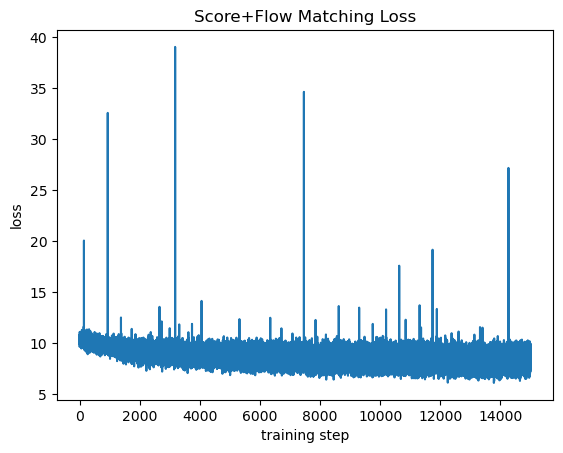

In [68]:
importlib.reload(models)

num_variables = 8
hidden_dim = 200
dims = [num_variables, hidden_dim, 1]
t = adatas[0].obs["t"].max()
wt_idx = [i for i, ko in enumerate(kos) if ko is None]
adatas_wt = [adatas[i] for i in wt_idx]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(adatas_wt[0].X)
adatas_wt[0].X = X_scaled

func_v = models.MLPODEF(dims=dims, GL_reg=0.01, bias=True)

score_net = MLP(d=num_variables, hidden_sizes=[hidden_dim], time_varying=True)

grouped_data = prepare_time_binned_data(adatas[0], time_column='t')
normalized_data, scaler = normalize_data(grouped_data)
pis = compute_all_pis_fixed(adatas_wt[0], t, reg=1e-1)  # all_pis

loss_history, flow_model, score_model = train_with_fmot_scorematching(
    func_v=func_v,
    func_s=score_net,
    adatas=adatas_wt[0],
    all_pis=pis,
    t=t,
    sigma=0.1,            # bridging noise
    dt=1.0,               
    alpha=0.1,            # score strength
    reg=1e-6,
    n_steps=15000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu",
    lr=3e-3
)


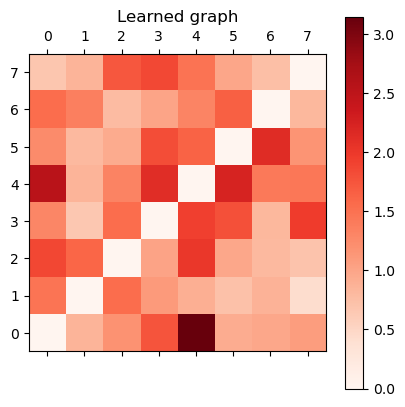

In [69]:
graph_sm = flow_model.causal_graph()  * (1-np.eye(8))
plt.matshow(graph_sm, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()


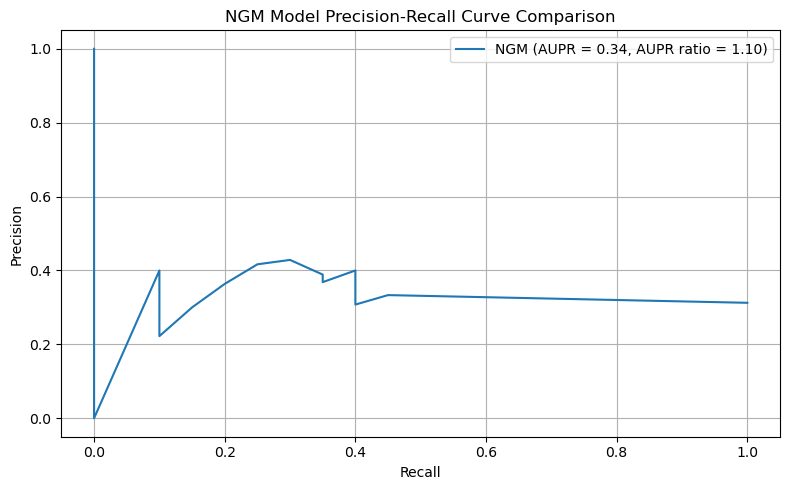

In [67]:
compare_models(graph_sm, true_matrix)

# Time varying with KO

In [133]:
def build_knockout_mask(d, h, ko_idx):
    """
    Build a [d, d] adjacency mask for a knockout of gene ko_idx.
    If ko_idx is None, return a mask of all ones (wild-type).
    """
    if ko_idx is None:
        # No knockout => no edges removed
        return np.ones((d, d), dtype=np.float32)
    else:
        mask = np.ones((d, d), dtype=np.float32)
        g = ko_idx
        # Zero row g => remove outgoing edges from gene g
        # mask[g, :] = 0.0
        # Zero column g => remove incoming edges to gene g
        mask[:, g] = 0.0
        return mask

In [134]:
class TimeVaryingMLPODEFwithKOmask(nn.Module):
    """
      fc1_list[t].weight: shape [d*d_hidden, d]
    """
    def __init__(self, dims, T=4, bias=True, GL_reg=0.01, knockout_masks=None):
        """
        dims: [d, hidden, 1]
        T: number of discrete time bins
        knockout_masks: a list of [d, d] arrays, one per dataset, or None if no KO
        """
        super().__init__()
        assert len(dims) >= 2 and dims[-1] == 1

        self.dims = dims
        self.T = T
        self.GL_reg = GL_reg  # adaptive lasso parameter

        d_in = dims[0] 
        d_hidden = dims[1]
        d_out = dims[-1] 

        self.fc1_list = nn.ModuleList([
            nn.Linear(d_in, d_in * d_hidden, bias=bias) for _ in range(T)
        ])

        self.fc2_list = nn.ModuleList([
            nn.Linear(d_hidden, d_out, bias=bias) for _ in range(T)
        ])

        self.elu = nn.ELU(inplace=True)

        self.knockout_masks = None
        if knockout_masks is not None:
            self.knockout_masks = [
                torch.tensor(m, dtype=torch.float32) for m in knockout_masks
            ]

    def forward(self, t_bins, x, dataset_idx=None):
        """
        t_bins: shape [batch_size], each in [0..T-1]
        x: shape [batch_size, 1, d]
        dataset_idx: either an int for the entire batch
        """
        batch_size, _, d = x.shape
        x = x.squeeze(1)  # => [batch_size, d]

        if dataset_idx is not None and self.knockout_masks is not None:
            mask = self.knockout_masks[dataset_idx].to(x.device)  # [d, d]
        else:
            mask = None

        x_out = []
        for i in range(batch_size):
            bin_idx = t_bins[i].item()

            fc1 = self.fc1_list[bin_idx]
            fc2 = self.fc2_list[bin_idx]

            w_raw = fc1.weight
            w_reshaped = w_raw.view(self.dims[0], self.dims[1], self.dims[0])

            if mask is not None:
                masked_w = w_reshaped * mask.unsqueeze(1)  # shape still [d, d_hidden, d]
            else:
                masked_w = w_reshaped

            # Now we do the matmul with x[i]
            # x[i:i+1, :] => shape [1, d]
            xi = x[i:i+1, :]  # shape [1, d]
            # We'll broadcast or do a manual matmul. We want output shape => [d, d_hidden].
            # Essentially each row => row dot x, but we have a hidden dimension in between.

            xi_out = torch.einsum("rhd,id->rh", masked_w, xi) # [r, h]

            xi_out = self.elu(xi_out)
            d_out_mat = fc2(xi_out)

            d_out_mat = d_out_mat.squeeze(-1).unsqueeze(0).unsqueeze(0)
            x_out.append(d_out_mat)

        return torch.cat(x_out, dim=0)

    def adjacency_for_bin(self, bin_idx, threshold=0.0):
        d = self.dims[0]
        d_hidden = self.dims[1]
        w = self.fc1_list[bin_idx].weight  # shape [d*d_hidden, d]
        w = w.view(d, d_hidden, d)  # => [d, hidden, d]
        W = torch.sqrt(torch.sum(w**2, dim=1))  # => [d, d]
        W = W.detach().cpu().numpy()
        if threshold > 0.0:
            W[W < threshold] = 0
        return W

    def aggregate_adjacency(self, mode='mean', threshold=0.0):
        d = self.dims[0]
        adjacency_list = []
        for t in range(self.T):
            Wt = self.adjacency_for_bin(t, threshold=0.0)
            adjacency_list.append(Wt)
        if mode == 'mean':
            W_agg = np.mean(adjacency_list, axis=0)
        elif mode == 'max':
            W_agg = np.max(adjacency_list, axis=0)
        elif mode == 'final':
            W_agg = adjacency_list[-1]
        else:
            raise ValueError(f'Unknown mode={mode}')
        if threshold > 0.0:
            W_agg[np.abs(W_agg) < threshold] = 0.0
        return W_agg

In [167]:
def train_discrete_time_ngm_multi_masked(
    model,
    adatas,
    all_pis_list,
    n_steps=5000,
    batch_size=64,
    device="cpu"
):
    def proximal(w, lam=0.1, eta=0.1):
        # same as before
        d = model.dims[0]
        d_hidden = model.dims[1]
        wadj = w.view(d, d_hidden, d)
        tmp = torch.sum(wadj**2, dim=1).sqrt() - lam * eta
        alpha = torch.clamp(tmp, min=0)
        v = F.normalize(wadj, dim=1) * alpha[:, None, :]
        w.data = v.view(-1, d)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_history = []

    import random
    total_steps = n_steps * 4
    for step in tqdm(range(0, total_steps-1)):
        # pick dataset randomly
        ds_idx = random.randrange(len(adatas))
        ad = adatas[ds_idx]
        pis = all_pis_list[ds_idx]

        # pick random bin
        # T_local = ad.obs["t"].max()
        # tb = random.randrange(T_local)
        tb = (step+1) // n_steps
        pi_matrix = pis[tb]
        if pi_matrix is None:
            continue

        # gather cells
        cells_t0 = torch.from_numpy(ad.X[ad.obs["t"] == tb]).float().to(device)
        cells_t1 = torch.from_numpy(ad.X[ad.obs["t"] == tb+1]).float().to(device)
        n0, n1 = cells_t0.shape[0], cells_t1.shape[0]
        if n0==0 or n1==0:
            continue

        # sample
        idx0 = np.random.randint(n0, size=batch_size)
        x0 = cells_t0[idx0]
        x1_list = []
        for row_i in idx0:
            row_pi = pi_matrix[row_i]
            row_pi = row_pi / row_pi.sum()
            choice = np.random.choice(n1, p=row_pi)
            x1_list.append(cells_t1[choice])
        x1 = torch.stack(x1_list, axis=0)

        # partial interpolation
        t_rand = torch.rand(batch_size, 1, device=device)
        xt = (1 - t_rand)*x0 + t_rand*x1
        ut = (x1 - x0)

        time_bins = torch.full((batch_size,), tb, dtype=torch.long, device=device)
        xt_in = xt.unsqueeze(1)

        vt = model(time_bins, xt_in, dataset_idx=ds_idx)
        vt = vt.squeeze(1)

        loss = F.mse_loss(vt, ut)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # proximal step
        proximal(model.fc1_list[tb].weight, model.GL_reg)

        loss_history.append(loss.item())
        if step % 500 == 0:
            with torch.no_grad():
                print(f"Step={step}, ds={ds_idx}, bin={tb}, Loss={loss.item():.4f}")
                W_agg = model.adjacency_for_bin(bin_idx=tb)
                plt.matshow(W_agg, cmap='Reds')
                plt.gca().invert_yaxis()
                plt.colorbar()
                plt.title("Learned graph")
                plt.show()

    return loss_history


In [136]:
knockout_masks = []
for i, ad in enumerate(adatas):
    d = ad.X.shape[1]
    mask_i = build_knockout_mask(d, ko_indices[i])  # returns [d,d]
    knockout_masks.append(mask_i)


In [161]:
for i,ad in enumerate(zip(adatas, ko_indices)):
    print(i,ad[0])

0 AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
1 AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
2 AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
3 AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
4 AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
5 Ann

  0%|          | 0/159999 [00:00<?, ?it/s]

Step=0, ds=0, bin=0, Loss=0.2827


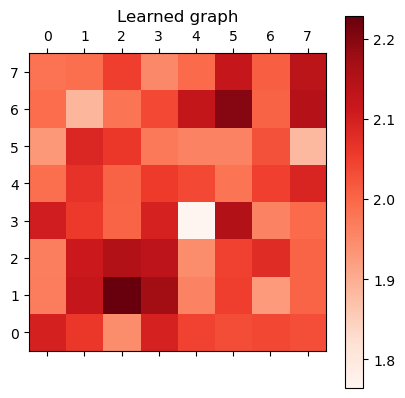

  0%|          | 498/159999 [00:14<1:19:38, 33.38it/s]

Step=500, ds=6, bin=0, Loss=0.1202


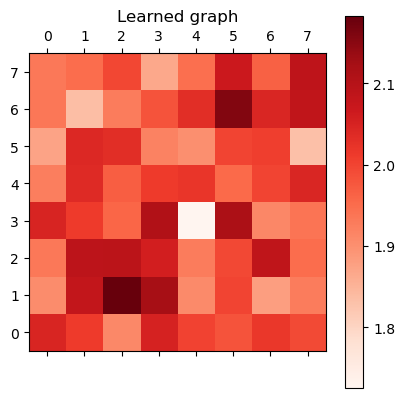

  1%|          | 1000/159999 [00:31<1:23:44, 31.64it/s]

Step=1000, ds=2, bin=0, Loss=0.0865


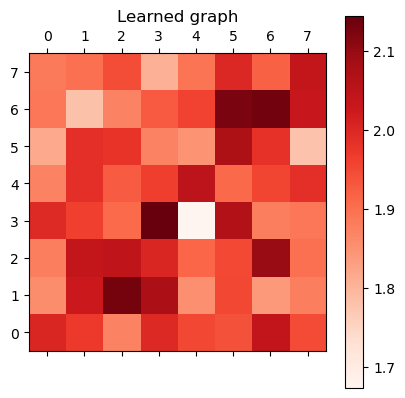

  1%|          | 1500/159999 [00:48<1:29:47, 29.42it/s]

Step=1500, ds=0, bin=0, Loss=0.0858


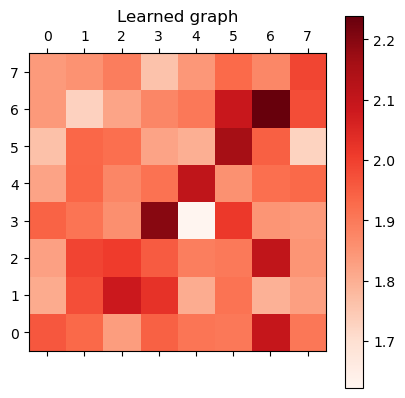

  1%|          | 1997/159999 [01:04<1:22:30, 31.92it/s]

Step=2000, ds=1, bin=0, Loss=0.0756


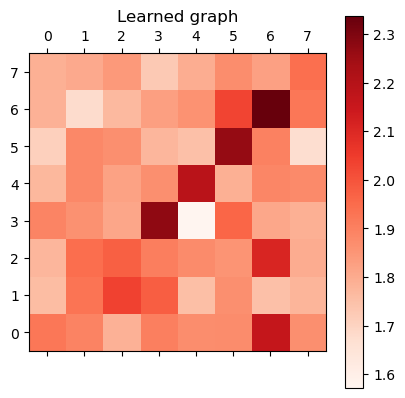

  2%|▏         | 2498/159999 [01:20<1:25:05, 30.85it/s]

Step=2500, ds=4, bin=0, Loss=0.0754


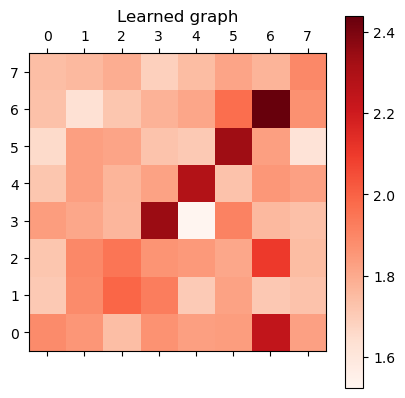

  2%|▏         | 2997/159999 [01:36<1:19:26, 32.94it/s]

Step=3000, ds=7, bin=0, Loss=0.0106


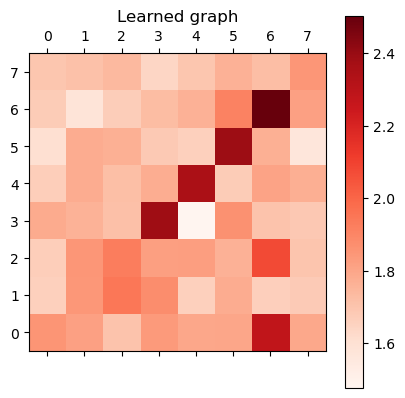

  2%|▏         | 3500/159999 [01:52<1:19:51, 32.66it/s]

Step=3500, ds=6, bin=0, Loss=0.0780


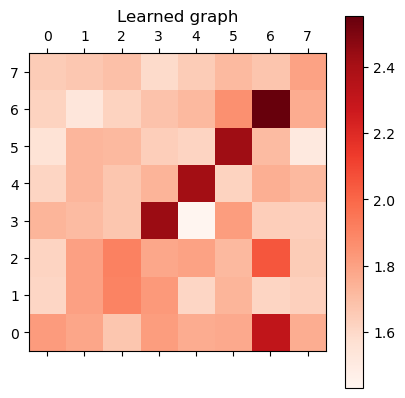

  3%|▎         | 4000/159999 [02:08<1:24:37, 30.72it/s]

Step=4000, ds=6, bin=0, Loss=0.0766


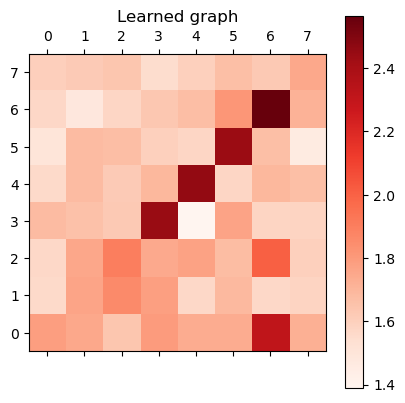

  3%|▎         | 4498/159999 [02:25<1:19:43, 32.51it/s]

Step=4500, ds=6, bin=0, Loss=0.0775


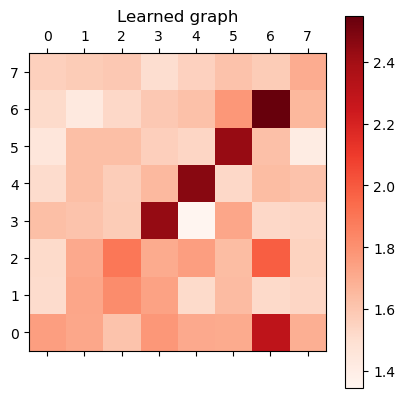

  3%|▎         | 4998/159999 [02:41<1:19:40, 32.43it/s]

Step=5000, ds=2, bin=0, Loss=0.0645


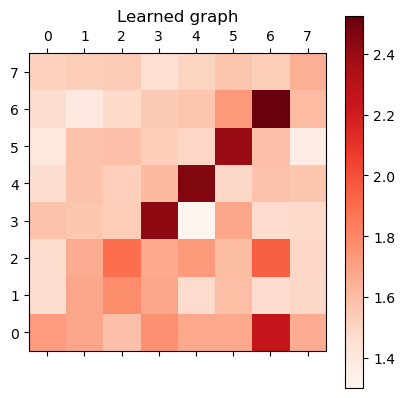

  3%|▎         | 5500/159999 [02:57<1:19:30, 32.39it/s]

Step=5500, ds=0, bin=0, Loss=0.0732


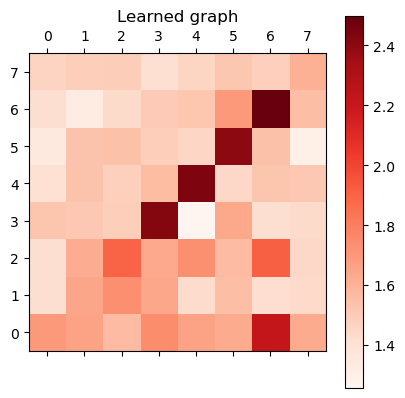

  4%|▎         | 5998/159999 [03:14<1:20:56, 31.71it/s]

Step=6000, ds=5, bin=0, Loss=0.0702


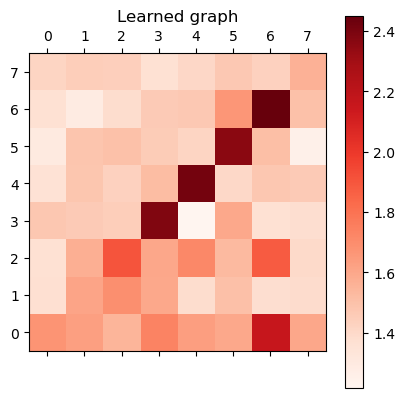

  4%|▍         | 6497/159999 [03:30<1:17:37, 32.96it/s]

Step=6500, ds=3, bin=0, Loss=0.0592


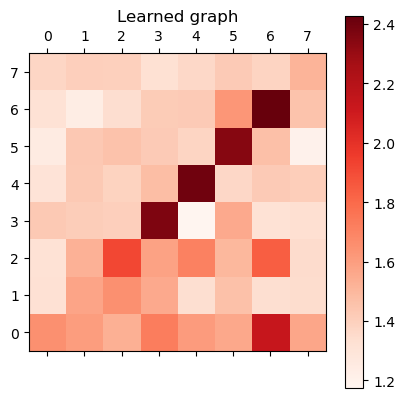

  4%|▍         | 6999/159999 [03:47<1:23:12, 30.65it/s]

Step=7000, ds=5, bin=0, Loss=0.0687


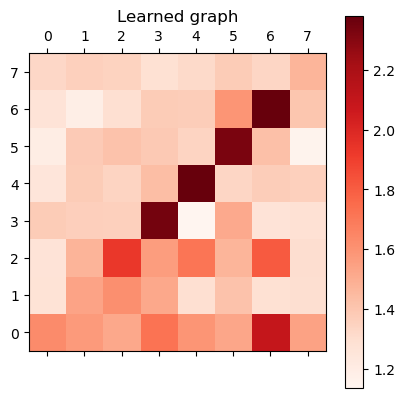

  5%|▍         | 7498/159999 [04:03<1:25:01, 29.89it/s]

Step=7500, ds=6, bin=0, Loss=0.0711


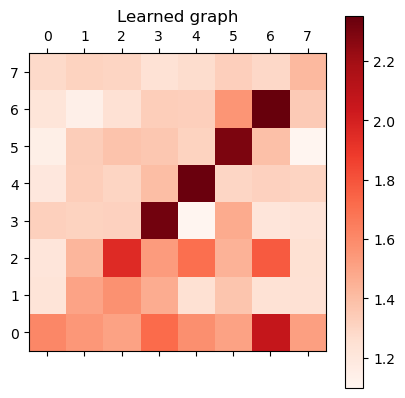

  5%|▍         | 7998/159999 [04:19<1:28:35, 28.60it/s]

Step=8000, ds=6, bin=0, Loss=0.0720


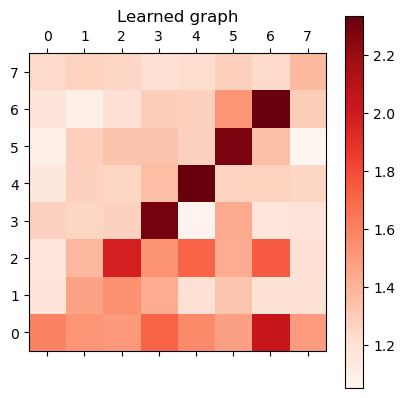

  5%|▌         | 8499/159999 [04:35<1:19:08, 31.90it/s]

Step=8500, ds=0, bin=0, Loss=0.0634


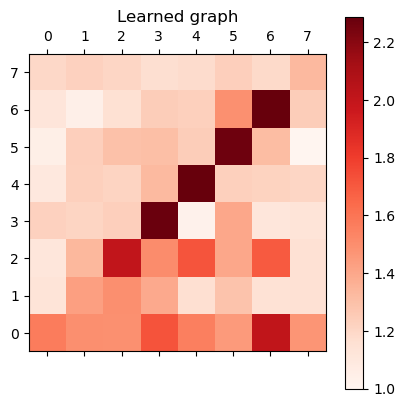

  6%|▌         | 8999/159999 [04:52<1:20:03, 31.43it/s]

Step=9000, ds=3, bin=0, Loss=0.0771


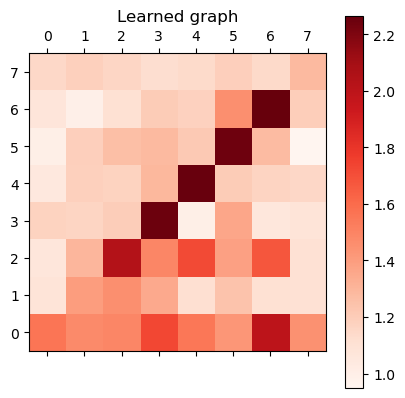

  6%|▌         | 9497/159999 [05:08<1:43:52, 24.15it/s]

Step=9500, ds=2, bin=0, Loss=0.0643


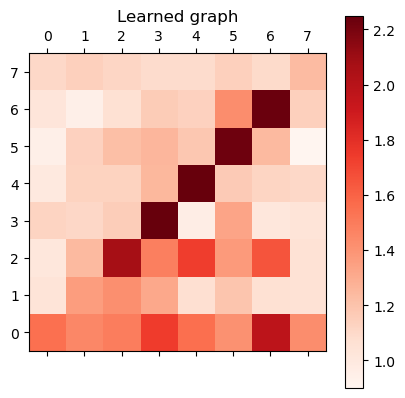

  6%|▌         | 9999/159999 [05:26<2:23:03, 17.48it/s]

Step=10000, ds=0, bin=0, Loss=0.0721


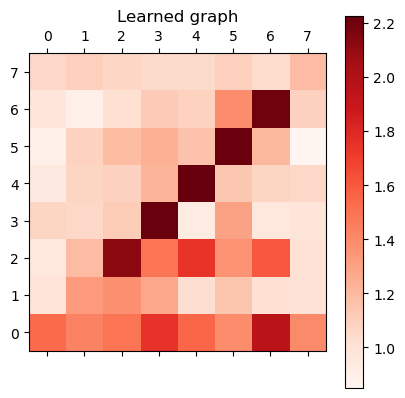

  7%|▋         | 10499/159999 [05:47<1:30:41, 27.47it/s]

Step=10500, ds=3, bin=0, Loss=0.0619


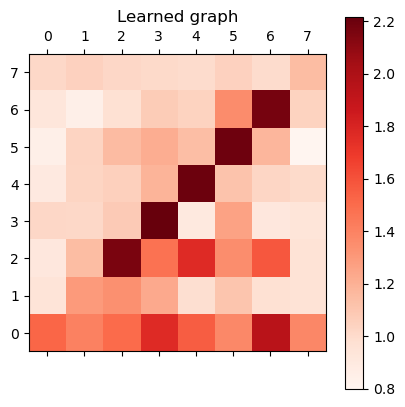

  7%|▋         | 11000/159999 [06:08<1:49:50, 22.61it/s]

Step=11000, ds=6, bin=0, Loss=0.0634


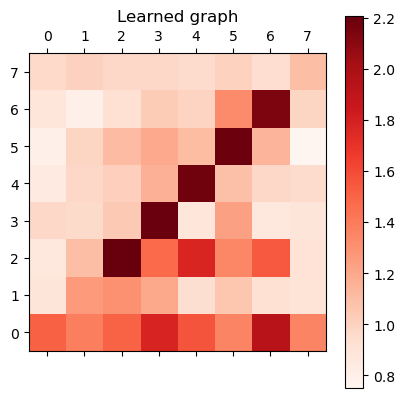

  7%|▋         | 11498/159999 [06:28<1:31:54, 26.93it/s]

Step=11500, ds=3, bin=0, Loss=0.0555


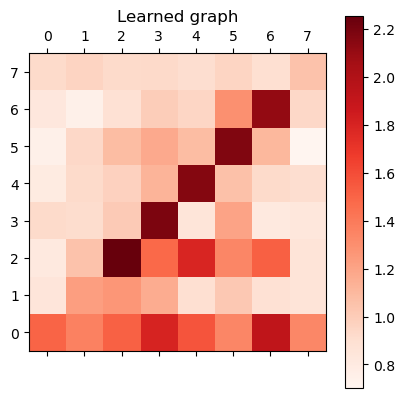

  8%|▊         | 12000/159999 [06:48<1:31:58, 26.82it/s]

Step=12000, ds=4, bin=0, Loss=0.0665


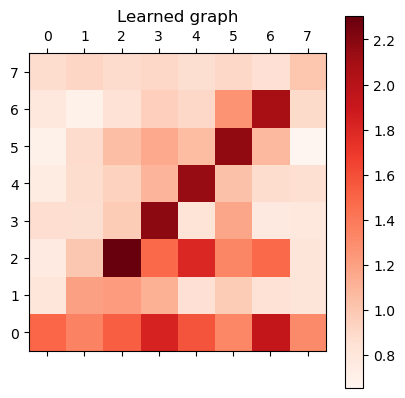

  8%|▊         | 12244/159999 [06:59<1:24:24, 29.18it/s]


KeyboardInterrupt: 

In [180]:
# 2) For each adata, compute all_pis
all_pis_list = []
# add knockout here. 
for i, ad in enumerate(zip(adatas, ko_indices)):
    T_local = ad[0].obs["t"].max()
    pi_list = compute_all_pis_fixed(ad[0], T_local, reg=1e-1, ko_index=ad[1])
    all_pis_list.append(pi_list)

# 3) Build masked model => T=4 if each dataset has time bins 0..3
model = TimeVaryingMLPODEFwithKOmask(
    dims=[8, 100, 1], 
    T=4, 
    GL_reg=0.001, 
    knockout_masks=knockout_masks
)

# 4) Train across all datasets
loss_history = train_discrete_time_ngm_multi_masked(
    model,
    adatas,
    all_pis_list,
    n_steps=40000,
    batch_size=164,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# 5) Evaluate adjacency or do your normal flow
W_agg = model.aggregate_adjacency(mode='mean')
plt.matshow(W_agg, cmap='Reds')
plt.show()

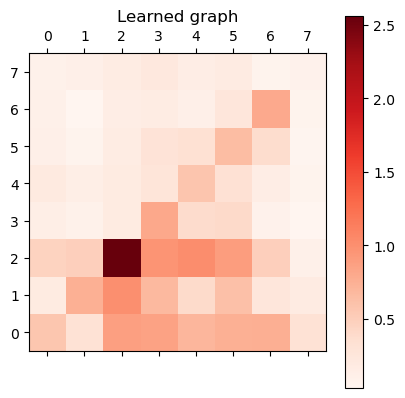

In [176]:
plt.matshow(W_agg, cmap='Reds')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

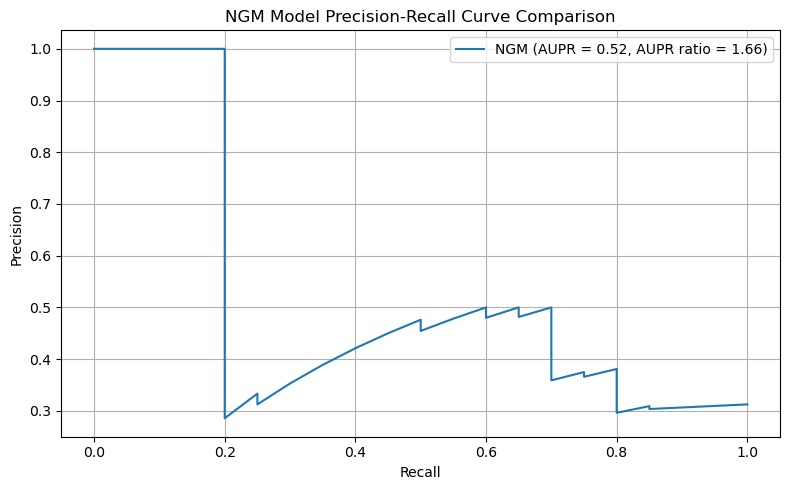

In [177]:
W_agg *= (1-np.eye(8))

compare_models(W_agg, true_matrix)

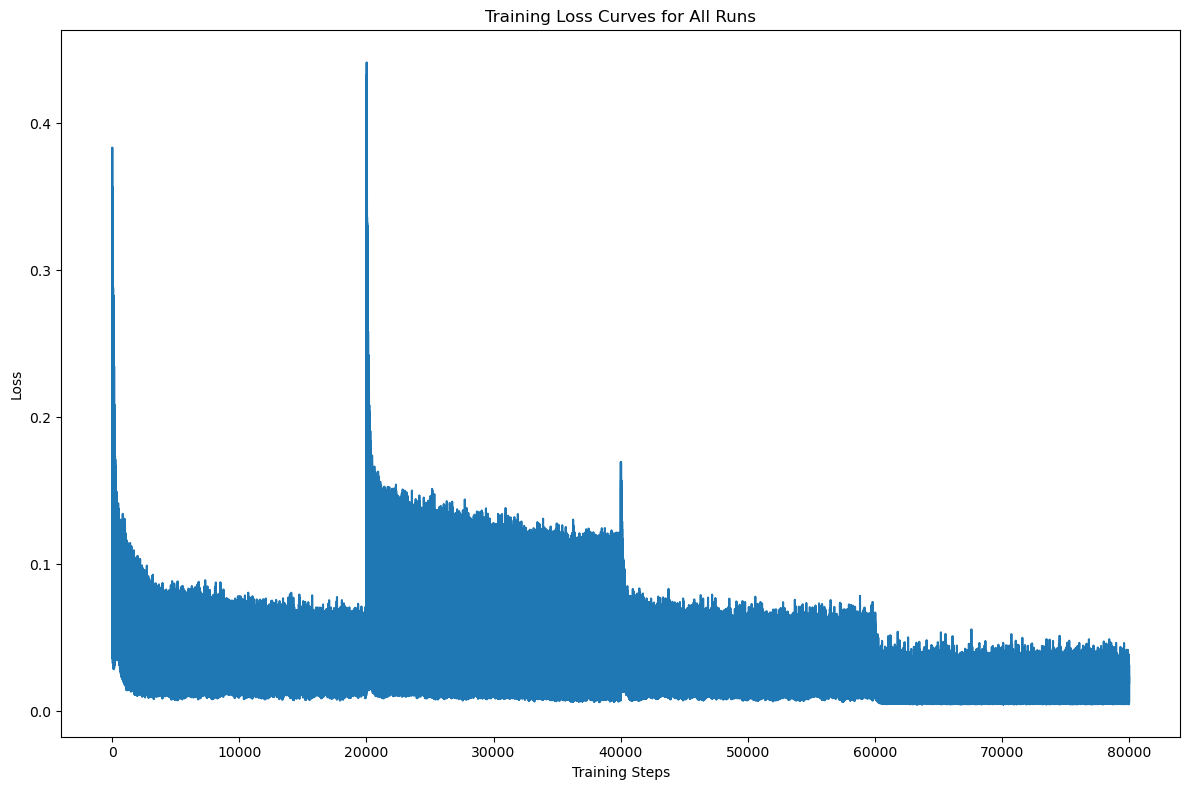

In [179]:
plt.figure(figsize=(12,8))
plt.plot(loss_history)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curves for All Runs")
plt.tight_layout()
plt.show()